In [1]:
# Author: Samantha Tetef
# Created: 8.26.20
# Title: XANESML

# This notebook analyzes hundreds of sulfur compounds K edge XANES spectra using a VAE

In [2]:
from utils import *

## to reload utils:
# from importlib import reload
# import utils as utils
# utils = reload(utils)
# from utils import *

from random import randint  

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import backend as K
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
from keras.activations import*
from keras.regularizers import l2
from keras.models import load_model

from sklearn import neighbors
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, NMF
from sklearn.manifold import TSNE

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
}

<IPython.core.display.Javascript object>

# Reading in spectra

Reading in compound names from lists (text files)

In [4]:
# setting up directory (this is unique to my own local machine)
ROOTDIR = os.getcwd()
TYPEdir = "Categories/"

### Creating dictionary list of compound categories

Spectrum must have been preprocessed using the SpectraFromDat python script

In [5]:
Data = get_XANES(Types, TYPEdir)
N = len(Data)
NAMES = get_Property(Data, 'name')

Compound has no conjugated category


In [6]:
# temporary fix for 2-2-Hydroxyphenyl_benzothiazole
for ele in Data:
    if ele['name'] == "2-2-Hydroxyphenyl_benzothiazole":
        x, y = ele['XANES']
        y = y*10
        ele['XANES'] = [x, y]

# XANES

In [7]:
XANES = np.array(get_Property(Data, 'XANES'))
NAMES = get_Property(Data, 'name')
XANESenergy = XANES[0,0,:]
X = XANES[:,1,:]

SCALING_FACTOR = np.max(X)
X = X/SCALING_FACTOR

In [8]:
test_list = get_text_in_file('Categories/TEST.txt').split('\n')
# test_list = ['2-Fluorocyclohexane-1-thiol']

TESTData = get_TEST_Data(test_list, directory='XANES')
TEST_NAMES = get_Property(TESTData, 'Name')

TEST_XANES_tuple = np.array(get_Property(TESTData, 'Spectra'))
TEST_XANES = TEST_XANES_tuple[:,1,:]

TEST_XANES = TEST_XANES/SCALING_FACTOR

In [9]:
def adjust_trans(trans, spectrum):
    xtemp, y = trans.copy()
    xtemp += 53.3
    
    bool_arr = xtemp < 2495
    x1 = xtemp[bool_arr]
    y1 = y[bool_arr]
    
    y1 /= np.max(y1)
    y1 *= np.max(spectrum)
    return x1, y1

In [10]:
# name = '2-Fluorocyclohexane-1-thiol'
# index = TEST_NAMES.index(name)

# trans1 = TESTData[index]['Transitions']
# x1 = TEST_XANES[index]

# trans_cut1 = adjust_trans(trans1, x1)
# emp = np.zeros(len(trans_cut1[0]), dtype=bool)
# emp[-1] = 1

# plot_spectrum_and_trans(trans_cut1, [XANESenergy, x1], f'{name}', figsize=(8,6),
#                         label='XANES', ylab=False, emp=emp)

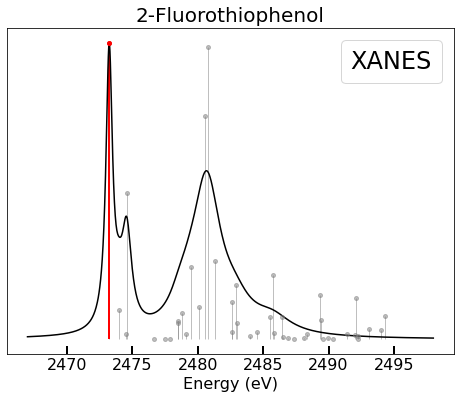

In [11]:
name = '2-Fluorothiophenol'
index = NAMES.index(name)

x2 = get_Spectrum(Data, name, mode='XANES')[1]/SCALING_FACTOR
trans2 = Data[index]['Transitions']

trans_cut2 = adjust_trans(trans2, x2)
emp = np.zeros(len(trans_cut2[0]), dtype=bool)
emp[-1] = 1
# emp[-4] = 1

plot_spectrum_and_trans(trans_cut2, [XANESenergy, x2],
                        f'{name}', figsize=(8,6),
                        label='XANES', ylab=False, emp=emp)

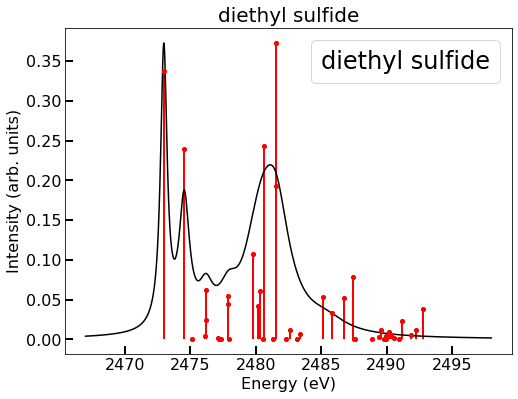

In [12]:
name = 'Ethyl_Sulfide'
index = NAMES.index(name)

x2 = get_Spectrum(Data, name, mode='XANES')[1]/SCALING_FACTOR
trans2 = Data[index]['Transitions']

trans_cut2 = adjust_trans(trans2, x2)
emp = np.ones(len(trans_cut2[0]), dtype=bool)

plot_spectrum_and_trans(trans_cut2, [XANESenergy, x2],
                        'diethyl sulfide', figsize=(8,6), label=None,
                        ylab=True, emp=emp)

In [13]:
# mn, mx = 130, -230
# in1 = [x1[mn:mx], trans_cut1]
# in2 = [x2[mn:mx], trans_cut2]
# names = ['2-Fluorocyclohexane-1-thiol', '2-Fluorothiophenol']
# stacked_trans(XANESenergy[mn:mx], in1, in2, names, method='XANES')

In [14]:
def get_x(name):
    x = get_Spectrum(Data, name, mode='XANES')[1]
    x = x/SCALING_FACTOR
    return x

In [15]:
def Spagetti_plot(Data, X=X):
    
    MIN, MAX = 0, -1
    
    fig, ax = plt.subplots(figsize=(8,18))
    base = 1
    
    i = 0
    
    for ele in Data:
        t = ele["Type"]
        y = X[i]
        
        if t == 1:
            y = y*1.4
        if t == 2:
            y = y*2
        if t == 3:
            y = y*1.6
      
        x = XANESenergy[MIN:MAX]
        y = y[MIN:MAX]
        
        if t == 5:
            y = y*0.8
            if i%3 == 0:
                plt.plot(x, y + t-1, '-', color=COLORS[t-1], alpha=0.1)
        elif t == 1:
            if i%5 != 0:
                plt.plot(x, y + t-1, '-', color=COLORS[t-1], alpha=0.1)
        else:
            plt.plot(x, y + t-1, '-', color=COLORS[t-1], alpha=0.1)        
        
        i += 1
      
    plt.plot([2470],[4.8],'wo')
                      
    plt.title(f"XANES Spectra", fontsize=30)
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks([2470,2475,2480,2485,2490,2495], [2470,'',2480,'',2490,''], fontsize=26)
    plt.yticks([],fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)

    plt.show()

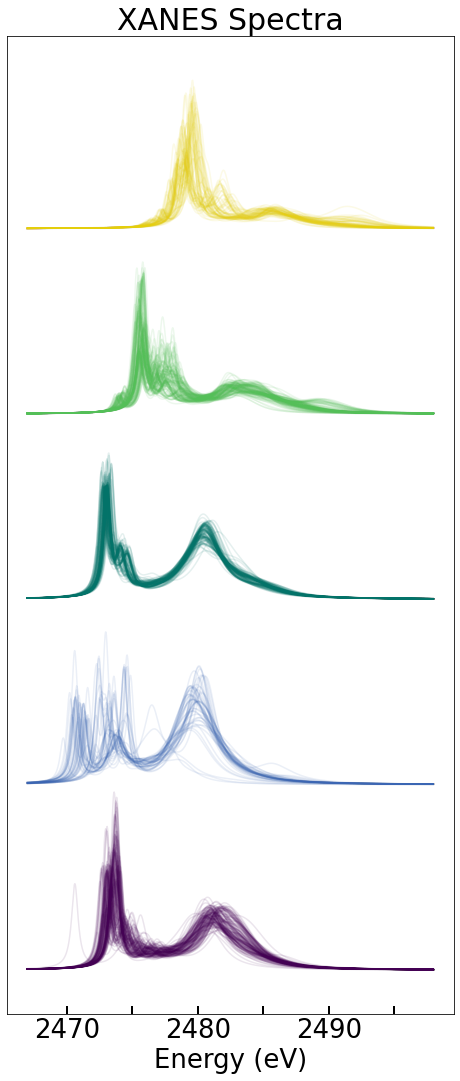

In [16]:
Spagetti_plot(Data, X=X)

In [17]:
# # ------------------------------------------------------------
# # ALIGNING WHITIELINES!
# # ------------------------------------------------------------
# temp_X = X.copy()

# def rebin(target_peak_energy, XANESenergy, x, max_E=-1):
    
#     n = len(XANESenergy)
#     x_new = np.zeros(n)
    
#     if max_E != -1:
#         max_i = index_from_array(XANESenergy, max_E)
#     else:
#         max_i = -1
    
#     peak_index = np.argmax(x[:max_i])   
#     target_peak_index = index_from_array(XANESenergy, target_peak_energy)
    
#     shift = peak_index - target_peak_index
    
#     if shift > 0:
#         for i in range(shift, len(XANESenergy)):
#             x_new[i - shift] = x[i]
#     else:       
#         shift = np.abs(shift)
#         for i in range(len(XANESenergy) - shift):
#             x_new[i + shift] = x[i]
    
#     return x_new
    
# for i in range(len(X)):
#     if Data[i]["Type"] == 2:
#         temp_X[i,:] = rebin(2475, XANESenergy, X[i,:], max_E = 2472)
#     else:
#         temp_X[i,:] = rebin(2475, XANESenergy, X[i,:])

# Spagetti_plot(Data, X=temp_X)
# X = temp_X.copy()

In [18]:
# names = ['Methionine', 'Cysteine']
# Spectra = [get_x(name) for name in names]
# stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(12,8), leg=1)

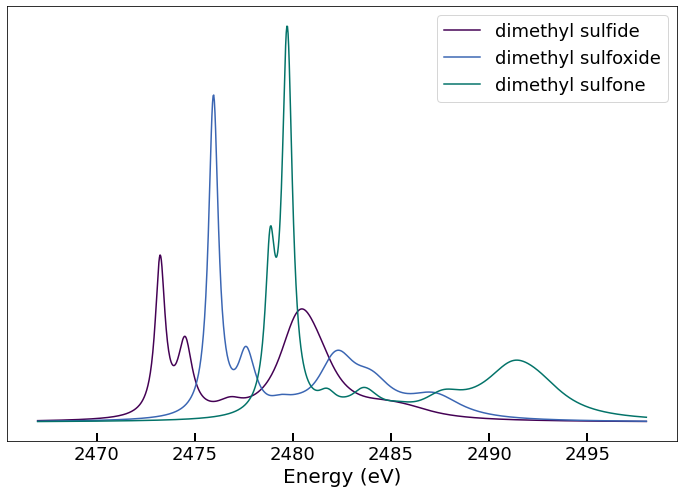

In [19]:
names = ['Dimethyl_Sulfide', 'Dimethyl_Sulfoxide', 'Dimethyl_sulfone']
Spectra = [get_x(name) for name in names]
names = ['dimethyl sulfide', 'dimethyl sulfoxide', 'dimethyl sulfone']
stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(12,8), leg=1)

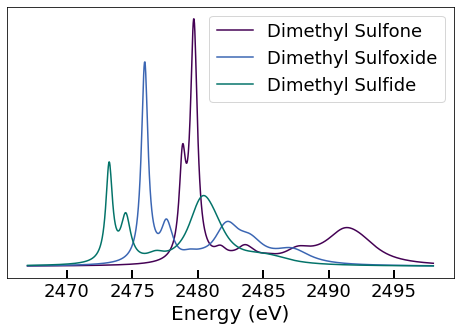

In [20]:
names = ['Dimethyl_sulfone','Dimethyl_Sulfoxide', 'Dimethyl_Sulfide']
Spectra = [get_x(name) for name in names]
names = ['Dimethyl Sulfone','Dimethyl Sulfoxide', 'Dimethyl Sulfide']
stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(8,5), leg=1)

In [21]:
# sub_Spagetti(Data)

=========================================================================================================================

# Data analysis

# Artificial Neural Network Section

### Network hyperparameters

In [22]:
# hidden layer dimensions
intermediate_dim_1 = 1024 

batch_size = 50
epochs = 30

train_size = 700

### Generating Labels

In [23]:
# PROPERTY = 'Type'
PROPERTY = 'oxy'
# PROPERTY = 'category'

In [24]:
Y = get_Property(Data, PROPERTY) #labels are one hot encoded

## Data pre-processing and shuffling

In [25]:
# random shuffle of data
Xshuffle, Yshuffle = shuffle_xy(X, Y)

#### Dividing data into training set, validation set, and test set

In [26]:
x_train = Xshuffle[:train_size]
y_train = Yshuffle[:train_size]

x_test = Xshuffle[train_size:]
y_test = Yshuffle[train_size:]

n_y = y_train.shape[1]
n_x = x_train.shape[1]

# Generating ANN Model

In [27]:
# input
Xin = Input(shape=(n_x,), name='spectra_input')
# model layers
lay = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2',
            name='hidden_layer_1')(Xin)
lay = Dropout(0.05)(lay)
# lay = Dense(intermediate_dim_2, activation='relu', name='layer_2')(lay)
nn_out = Dense(n_y, activation='softmax', name='classifier')(lay)

ANN = Model(Xin, nn_out)

ANN.compile(optimizer='adam', loss='binary_crossentropy')
ANN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectra_input (InputLayer)   [(None, 1000)]            0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1024)              1025024   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
classifier (Dense)           (None, 3)                 3075      
Total params: 1,028,099
Trainable params: 1,028,099
Non-trainable params: 0
_________________________________________________________________


### Training

In [28]:
# ANN.fit(x_train, y_train, 
#          shuffle=True, batch_size=batch_size, epochs=epochs,
#          validation_data=(x_test, y_test))
# ANN.save(f'models/XANES_ANN_{PROPERTY}.h5')

In [29]:
PROPERTY = 'Type'
# PROPERTY = 'oxy'
# PROPERTY = 'category'
ANN = load_model(f'models/XANES_ANN_{PROPERTY}.h5', compile=False)

# Prediction Results

In [30]:
if PROPERTY == 'oxy':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 3))
    for i,o in enumerate(TEST_OXY):
        one_hot_encoded_label[i,o-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)
if PROPERTY == 'Type':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 5))
    for i,t in enumerate(TEST_TYPE):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)
if PROPERTY == 'category':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 10))
    for i,t in enumerate(TEST_CAT):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)

In [31]:
totalTestAccuracy = sum(1 for i in range(len(pred)) if pred[i] == true[i])/len(pred)
print(f"Total accuracy on test data: {totalTestAccuracy} of {len(pred)} compounds")

Total accuracy on test data: 0.8461538461538461 of 52 compounds


### Confusion Matrix

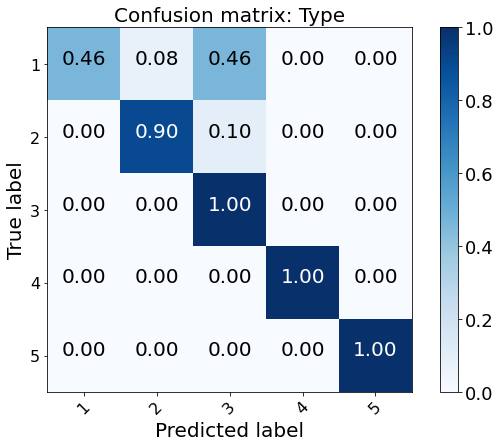

In [32]:
if PROPERTY == 'Type':    
    make_confusion_matrix(true, pred, Types, PROPERTY)
if PROPERTY == 'oxy':
    make_confusion_matrix(true, pred, Oxys, PROPERTY)
if PROPERTY == 'category':
    make_confusion_matrix(true, pred, Categories, PROPERTY)

=========================================================================================================================

# VAE Categorization

In [33]:
# hidden layer dimensions
intermediate_dim_1 = 512
intermediate_dim_2 = 246
latent_dim = 2

batch_size = 50
epochs = 120

dropout = 0.15 #0.2

activation='relu'

In [34]:
# class Sampling(tf.keras.layers.Layer):
#     """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [35]:
# # input
# Xin = Input(shape=(n_x,), name='spectra_input')

# #activity_regularizer=l2(l2_rate)

# # encoder
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(Xin)
# x = Dropout(dropout)(x)
# x = Dense(intermediate_dim_2, activation=activation, kernel_regularizer='l2')(x)
# x = Dropout(dropout)(x)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# # z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# z = Sampling()([z_mean, z_log_var])

# # encoder
# encoder = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# # decoder
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(latent_inputs)
# x = Dropout(dropout)(x)
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(x)
# x = Dropout(dropout)(x)
# outputs = Dense(n_x, activation='sigmoid')(x)

# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# Output = decoder(encoder(Xin)[2])
# vae = Model(Xin, Output, name='VAE')

# reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae.add_loss(vae_loss)

# vae.compile(optimizer='adam')

# history = vae.fit(x_train,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_data=(x_test, None))

In [36]:
# vae.save('models/XANES_VAE', save_format="tf")
# encoder.save('models/XANES_encoder', save_format="tf")
# decoder.save('models/XANES_decoder', save_format="tf")

In [37]:
vae = load_model('models/XANES_VAE', compile=False)
encoder = load_model('models/XANES_encoder', compile=False)
decoder = load_model('models/XANES_decoder', compile=False)
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spectra_input (InputLayer)      [(None, 1000)]       0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 639698      spectra_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 1000)         777192      encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          512512      spectra_input[0][0]              
                                                                 spectra_input[0][0]            

In [38]:
# copy pasted from XESML
# xes_loss = np.array([587.4163208007812, 289.7535095214844, 235.5487518310547, 219.5084686279297, 212.82444763183594, 209.2156219482422, 206.50743103027344, 205.59414672851562, 203.83714294433594, 202.40573120117188, 201.30972290039062, 200.91807556152344, 200.20797729492188, 198.9169464111328, 198.54226684570312, 197.57217407226562, 196.9044647216797, 196.51730346679688, 196.10800170898438, 195.96981811523438, 195.58645629882812, 195.17782592773438, 194.9303741455078, 194.8458251953125, 194.57009887695312, 194.4072723388672, 194.02676391601562, 193.9930419921875, 193.73245239257812, 193.5954132080078, 193.58607482910156, 193.28297424316406, 193.13406372070312, 192.95486450195312, 192.94143676757812, 192.711669921875, 192.64797973632812, 192.4241180419922, 192.54666137695312, 192.45594787597656, 192.3738250732422, 192.21609497070312, 192.0460205078125, 192.06813049316406, 191.87437438964844, 191.6284637451172, 191.53512573242188, 191.32748413085938, 191.18458557128906, 190.96182250976562, 190.77999877929688, 190.6433563232422, 190.4116973876953, 190.34751892089844, 190.0126953125, 189.8665771484375, 189.70053100585938, 189.70518493652344, 189.522216796875, 189.39083862304688, 189.296875, 189.22242736816406, 189.1047821044922, 189.0765380859375, 189.00808715820312, 189.04383850097656, 188.93336486816406, 189.00196838378906, 188.86767578125, 188.87838745117188, 188.86474609375, 188.677978515625, 188.83889770507812, 188.8516845703125, 188.75643920898438, 188.76602172851562, 188.57406616210938, 188.64712524414062, 188.70254516601562, 188.6536865234375, 188.68826293945312, 188.71859741210938, 188.72817993164062, 188.68235778808594, 188.6370391845703, 188.59071350097656, 188.51248168945312, 188.56654357910156, 188.60508728027344, 188.49110412597656, 188.40243530273438, 188.39938354492188, 188.45364379882812, 188.47984313964844, 188.5147247314453, 188.462646484375, 188.4756622314453, 188.45631408691406, 188.4014892578125, 188.51417541503906, 188.3063201904297, 188.3390655517578, 188.34658813476562, 188.384765625, 188.46426391601562, 188.37205505371094, 188.35264587402344, 188.2953338623047, 188.3475799560547, 188.3788604736328, 188.34207153320312, 188.2994842529297, 188.3293914794922, 188.30763244628906, 188.33200073242188, 188.2676544189453, 188.20565795898438, 188.30099487304688, 188.3021240234375, 188.3164825439453])
# xes_val_loss = np.array([346.8323059082031, 246.225341796875, 224.42642211914062, 215.96360778808594, 211.27345275878906, 208.4990692138672, 206.29312133789062, 204.4748077392578, 204.44627380371094, 203.5107879638672, 201.87852478027344, 202.4175262451172, 202.30313110351562, 200.8977508544922, 199.2266082763672, 198.39215087890625, 197.66590881347656, 197.93704223632812, 198.3144989013672, 197.57135009765625, 196.82815551757812, 197.28977966308594, 196.3883056640625, 196.32765197753906, 195.81593322753906, 196.8367156982422, 195.54415893554688, 195.62374877929688, 195.3625030517578, 196.1329803466797, 194.63760375976562, 195.19976806640625, 195.12294006347656, 194.79791259765625, 194.91551208496094, 194.45570373535156, 194.64332580566406, 194.26771545410156, 194.2083740234375, 194.47360229492188, 194.08761596679688, 193.97515869140625, 194.1699981689453, 193.87933349609375, 194.17970275878906, 193.85716247558594, 193.21180725097656, 193.21832275390625, 193.2945556640625, 193.23414611816406, 192.95335388183594, 193.10400390625, 192.85543823242188, 192.3883819580078, 192.2591552734375, 191.67233276367188, 192.2103271484375, 191.4141845703125, 191.30606079101562, 191.69781494140625, 191.07762145996094, 191.08543395996094, 190.86289978027344, 191.19139099121094, 191.12693786621094, 191.41961669921875, 190.85488891601562, 190.6076202392578, 191.1174774169922, 190.9752197265625, 190.82057189941406, 190.3340606689453, 190.41099548339844, 190.62205505371094, 191.0916748046875, 191.08103942871094, 191.06820678710938, 191.1313934326172, 190.4407958984375, 191.11041259765625, 190.34962463378906, 190.5491180419922, 190.9296417236328, 190.93478393554688, 190.72142028808594, 190.34625244140625, 191.04705810546875, 190.51583862304688, 190.69326782226562, 190.4501953125, 190.8927764892578, 190.2116241455078, 190.27056884765625, 190.06187438964844, 190.7169189453125, 190.17642211914062, 190.8031768798828, 190.86965942382812, 191.1562042236328, 190.30752563476562, 190.2003936767578, 190.61492919921875, 190.2936553955078, 190.61207580566406, 190.18008422851562, 190.37867736816406, 190.09913635253906, 190.2353973388672, 190.40492248535156, 190.10885620117188, 191.0023193359375, 190.5455780029297, 190.69032287597656, 190.1829376220703, 190.71221923828125, 190.41909790039062, 190.44664001464844, 190.3867950439453, 190.63941955566406, 190.24461364746094])

In [39]:
# show_loss(history, 'XANES')
# show_combined_loss(history, [xes_loss, xes_val_loss])

In [40]:
def plot(PROPERTY, x_predict, y_predict, encoder, X, test_index=None, mode='VtC-XES',
         extra_name=None, a=.3, s=5, black=False):
     
    z_mean = encoder.predict(x_predict, batch_size=1)[0]
    
    fontsize=28
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    cbar_vis = True
    
    if PROPERTY == 'oxy':
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=cmap)
        ticks = Oxys
        label = 'Oxidation'
        loc = [-1.33, 0, 1.33]
        
    elif PROPERTY == 'category':
        Colors = list(COLORMAP(np.arange(1,11)/9))
        label = "Category"
            
        for i in range(10):
            Colors[i] = (128/255,128/255,128/255,0.2)
            
        # type 1
        Colors[0] = COLORS[0].copy()
        Colors[1] = '#9F5F80'
        # type 2
        Colors[2] = '#03506F'
        Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
        # type 3
        Colors[4] = '#DB6400'
        Colors[5] = '#ffba93'
        # type 4
        Colors[6] = '#2b3016'
        Colors[7] = COLORS[3].copy()
        # type 5
        Colors[8] = '#ac3501'
        Colors[9] = COLORS[4]
            
        t1a = mpatches.Patch(color=Colors[0], label='Type 1')
        t1b = mpatches.Patch(color=Colors[1], label='Type 1')
        t2a = mpatches.Patch(color=Colors[2], label='Type 2')
        t2b = mpatches.Patch(color=Colors[3], label='Type 2')
        t3a = mpatches.Patch(color=Colors[4], label='Type 3')
        t3b = mpatches.Patch(color=Colors[5], label='Type 3')
        t4a = mpatches.Patch(color=Colors[6], label='Type 4')
        t4b = mpatches.Patch(color=Colors[7], label='Type 4')
        t5a = mpatches.Patch(color=Colors[8], label='Type 5')
        t5b = mpatches.Patch(color=Colors[9], label='Type 5')
        space = mpatches.Patch(color='w', label='')
        aro = mpatches.Patch(color='w', label='Aromatic')
        ali = mpatches.Patch(color='w', label='Aliphatic')
          
            
        fig.subplots_adjust(right=0.75)
        handles = [ali, t1a,t2a, t3a, t4a, t5a, space, aro, t1b, t2b, t3b, t4b, t5b]
        leg1 = plt.legend(handles=handles, ncol=1, fontsize=20, handletextpad=0.001,
                              bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        plt.gca().add_artist(leg1)
        i = 0
        for patch in leg1.get_patches():
            patch.set_height(15)
            if i in [0, 7]:
                patch.set_width(0.1)
            else:
                patch.set_width(30)
            i += 1
        
        ax.annotate(f'{mode}:\nVAE',
            xy=(0.03,0.85), xycoords='axes fraction',
            textcoords='offset points',
            size=fontsize)
        
        cbar_vis = False
        
        # actually plotting
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)

        
    elif PROPERTY == 'Type':
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        ticks = Types
        label = 'Type'
        loc = [1.4, 2.2, 3, 3.8, 4.6]
        if test_index is not None:
            ztest = encoder.predict(TEST_XES)[0]
            if test_index is 'all':
                plt.scatter(ztest[:, 0], ztest[:, 1], c='r', s=35)
            else:
                plt.plot(ztest[test_index, 0], ztest[test_index, 1], 'r.', markersize=15)
        
    else:
        
        z_meanX = encoder.predict(X, batch_size=batch_size)[0]
        Y = one_hot_to_num(get_Property(Data, 'oxy'))
        
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c=Y*2-4, cmap=cmap)
        if z_mean.shape[0] > 5:
            alpha, color, ms = a, 'k', s
            plt.plot(z_mean[:, 0], z_mean[:, 1], '.-', c=color, alpha=alpha, markersize=ms)
        else:
            alpha, ms = a, s
            for i,pt in enumerate(z_mean):
                if i in [2,3]:
                    c='k'
                else:
                    c='#eb5600'
                plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+5, fillstyle='none')
                plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+3, fillstyle='none')
                plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+1, fillstyle='none')
            extra_name = None
        label = 'Oxidation'
        ticks = Oxys
        loc = [-1.33, 0, 1.33]
        if extra_name is not None:
            x = np.array([get_x(extra_name)])
            extra_name = extra_name.lower().replace('_' , ' ')
            z_loc = encoder.predict(x, batch_size=1)[0]
            plt.plot(z_loc[:, 0], z_loc[:, 1], '.', c='r', alpha=1., markersize=15, label=extra_name)
            plt.legend(fontsize=20)
    
    if black:
        z_meanX = encoder.predict(X, batch_size=batch_size)[0]
        Y = one_hot_to_num(get_Property(Data, 'oxy'))
        plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c='k')
        cbar_vis=False
    
    if cbar_vis:
        cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
        cbar = plt.colorbar(cax=cbaxes, ticks=ticks)
        cbar.set_label(label, fontsize=26)
        cbar.set_ticks(loc)
        cbar.ax.tick_params(labelsize=26)
        cbar.set_ticklabels(ticks)
        if extra_name is None:
            legend = ax.legend(['VAE'], markerscale=0.01, handlelength=0, handletextpad=0,
                               fancybox=True, fontsize=fontsize+12)
            for item in legend.legendHandles:
                item.set_visible(False)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

In [41]:
def find_most_similar(Data, spectra):
    min_error = np.Infinity
    name, most_similar = None, None
    for ele in Data:
        ref = ele['XANES'][1,:]
        ref = ref/np.max(ref)
        err = np.sqrt(np.sum((ref - spectra)**2))
        if err < min_error:
            min_error = err
            most_similar = ref
            name = ele['name']
    return name, most_similar

In [42]:
Is = [0, 200, 300, 450, 700]
x_decode = np.array([X[i] for i in Is])
decode_names = np.array([NAMES[i] for i in Is])
print(decode_names)

['1,3-Thiazol-4-ylacetic_acid' 'Protionamide' '4-dimethylamino-thiophenol'
 'Dl-Ethionine_sulfoxide' 'Tetrachlorothiophene-sulfone']


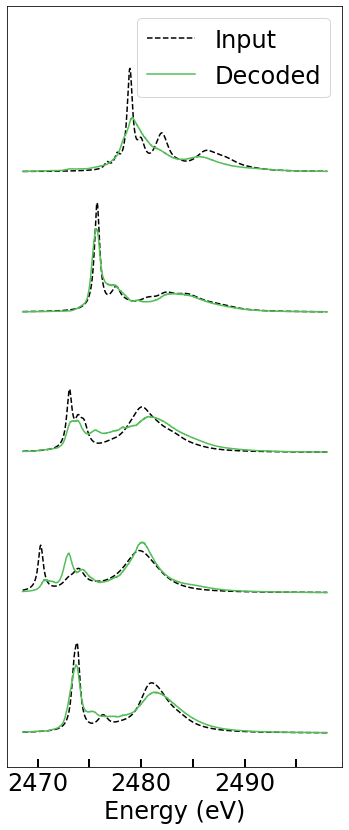

In [43]:
plot_in_v_out(XANESenergy, vae, x_decode, decode_names, figsize=(6,14), c=3, x_range=(50,-1), method='XANES')

In [44]:
PROPERTIES = ['oxy', 'Type', 'category']
Labels = []
for PROPERTY in PROPERTIES:
    Labels.append(get_Property(Data, PROPERTY))

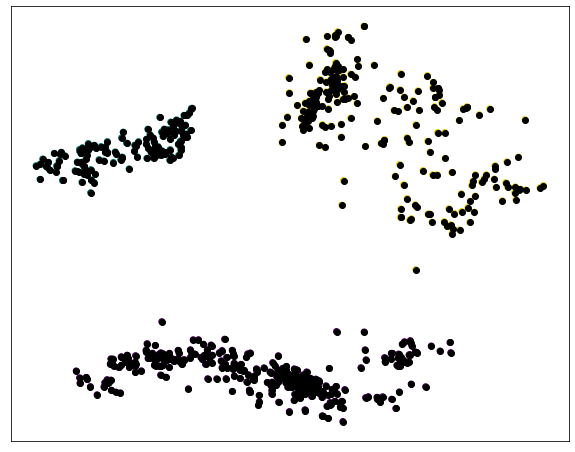

In [45]:
plot(PROPERTIES[0], X, Labels[0], encoder, X, black=True)

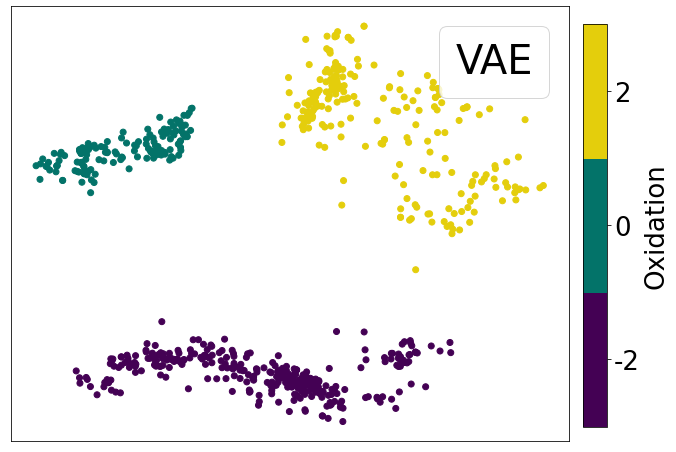

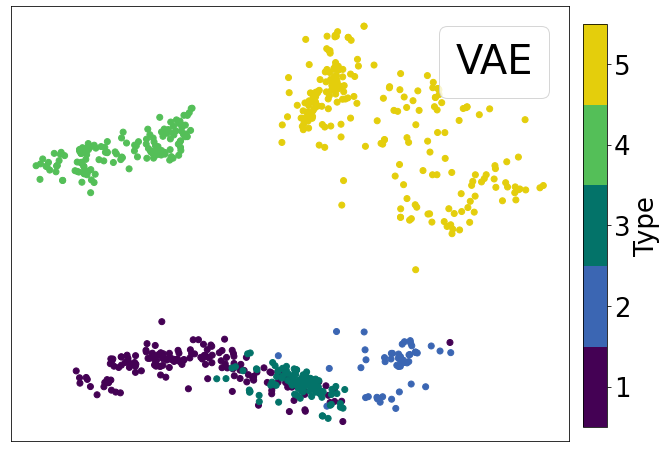

In [46]:
for PROPERTY in PROPERTIES[:2]:
    if latent_dim is 2:
        plot(PROPERTY, X, Labels[PROPERTIES.index(PROPERTY)], encoder, X)

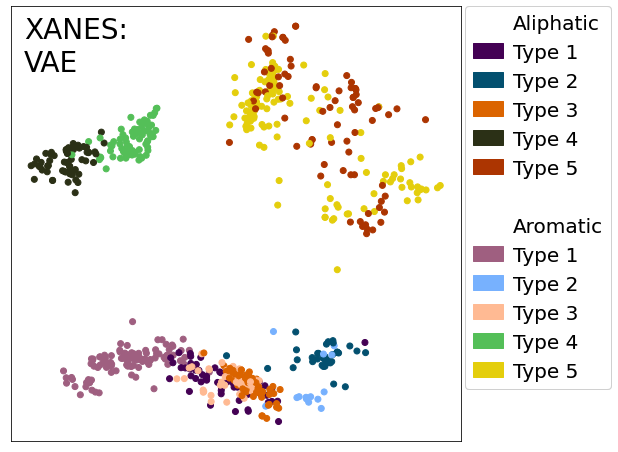

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot('category', X, Labels[2], encoder, X, mode='XANES')

In [48]:
def get_type_eles(Data, t):
    temp = []
    for ele in Data:
        if ele['Type'] == t:
            temp.append(ele)
    return temp

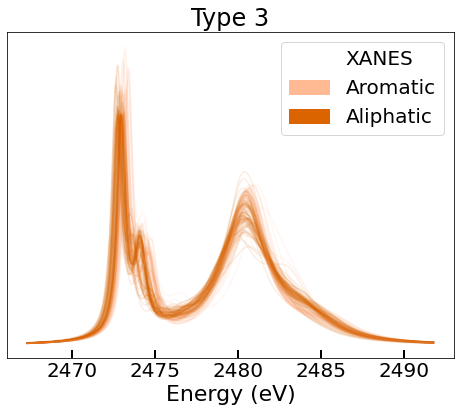

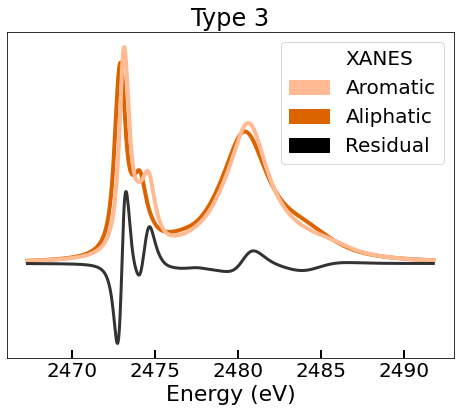

In [49]:
type_spagetti(XANESenergy, NAMES, Data, 'XANES', X, Type=3, space=0., figsize=(8,6), alpha=0.1) 

### K means

In [50]:
def plot_centroids(x_predict, y_predict, codebook):
    
    z_mean = encoder.predict(x_predict, batch_size=batch_size)[0]
    
    fontsize=16
    fig, ax = plt.subplots(figsize=(12, 8))
    if PROPERTY == 'oxy':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=COLORMAP)
        plt.colorbar(ticks=Oxys)
        plt.title("Latent Space vs Sulfur Oxidation", fontsize=fontsize+4)
    elif PROPERTY == 'category':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=COLORMAP)
        plt.colorbar()
        plt.title("Latent Space vs Category", fontsize=fontsize+4)
    else:
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        cbar = plt.colorbar(ticks=Types)
#         plt.title("Latent Space vs Type", fontsize=fontsize+4)
    
    plt.plot(codebook[:, 0], codebook[:, 1], '.', c='r', markersize=20)
    
    cbar.set_label(PROPERTY, fontsize=26)
    cbar.ax.tick_params(labelsize=22)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

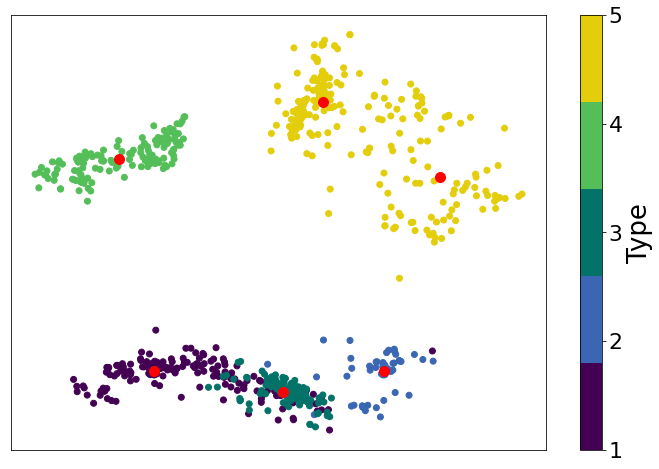

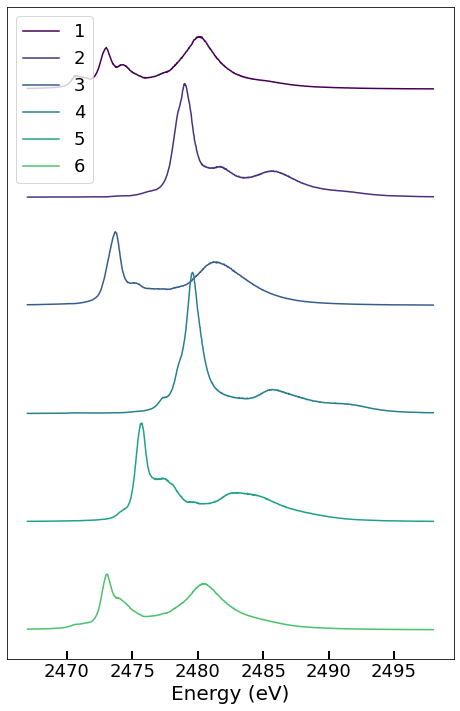

In [51]:
PROPERTY = 'Type'
z_mean = encoder.predict(X)[0]
codebook, distortion = kmeans(z_mean, 6)
plot_centroids(X, Labels[PROPERTIES.index(PROPERTY)], codebook)
Spectra = decoder.predict(codebook)
stack_plot(XANESenergy, Spectra, np.arange(len(codebook))+1, title=f'', space=0.5, figsize=(8,12))

# One Type VAE

In [52]:
# # 'Aliphatic', 'Aromatic'
# myType = 1
# x_one = []
# y_one = []
# for ele in Data:
#     if ele['Type'] in [1,2,3]:
# #     if ele['Type'] == myType:
#         x = ele['XANES'][1]
#         x = x - np.min(x)
#         x = x/np.max(x)
#         x_one.append(x)
#         y = ele['category']
#         y_one.append(y)

# x_one = np.array(x_one)
# y_one = np.array(y_one)

# x_one, y_one = shuffle_xy(x_one, y_one)

In [53]:
# n_x = 1000
# intermediate_dim_1 = 256

# # input
# Xin = Input(shape=(n_x,), name='spectra_input')

# # encoder
# x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(Xin)
# x = Dropout(0.01)(x)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# # encoder
# encoder3 = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# # decoder
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(latent_inputs)
# x = Dropout(0.01)(x)
# outputs = Dense(n_x, activation='sigmoid')(x)

# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# Output = decoder(encoder3(Xin)[2])
# vae2 = Model(Xin, Output, name='VAE')

# reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae2.add_loss(vae_loss)
# vae2.compile(optimizer='adam')

In [54]:
# training_size = [150, 45, 120, 130, 210]
# type_size = training_size[myType-1]
# type_size = 345
# vae2.fit(x_one[:type_size],
#         epochs=45,
#         batch_size=30,
#         validation_data=(x_one[type_size:], None))

In [55]:
# plot('all', x_one, y_one, encoder3, x_one)

# PCA

In [56]:
def plot_dim_red(PROPERTY, X_red, Y, method, xloc=0.65, fontsize=28, black=False, Indices=None,
                 mode='VtC-XES', indices=None, special_label=None):
    
    cbar_vis=True
    
    Colors = list(COLORMAP(np.arange(1,11)/9))
    for i in range(10):
        Colors[i] = (128/255,128/255,128/255,0.2)
            
    # type 1
    Colors[0] = COLORS[0].copy()
    Colors[1] = '#9F5F80'
    # type 2
    Colors[2] = '#03506F'
    Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
    # type 3
    Colors[4] = '#DB6400' #'#ac3501'
    Colors[5] = '#ffba93' #'#f89345'
    # type 4
    Colors[6] = '#2b3016' 
    Colors[7] = COLORS[3].copy()
    # type 5
    Colors[8] = '#ac3501'
    Colors[9] = COLORS[4]

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    if PROPERTY == 'oxy':
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y)*2-4, cmap=cmap)
        ticks=Oxys
        label = 'Oxidation'
        loc = [-1.33, 0, 1.33]
        
    elif PROPERTY == 'category':
        
        label = "Category"
        
        Y = one_hot_to_num(Y)
        
        t1a = mpatches.Patch(color=Colors[0], label='Type 1')
        t1b = mpatches.Patch(color=Colors[1], label='Type 1')
        t2a = mpatches.Patch(color=Colors[2], label='Type 2')
        t2b = mpatches.Patch(color=Colors[3], label='Type 2')
        t3a = mpatches.Patch(color=Colors[4], label='Type 3')
        t3b = mpatches.Patch(color=Colors[5], label='Type 3')
        t4a = mpatches.Patch(color=Colors[6], label='Type 4')
        t4b = mpatches.Patch(color=Colors[7], label='Type 4')
        t5a = mpatches.Patch(color=Colors[8], label='Type 5')
        t5b = mpatches.Patch(color=Colors[9], label='Type 5')
        space = mpatches.Patch(color='w', label='')
        aro = mpatches.Patch(color='w', label='Aromatic')
        ali = mpatches.Patch(color='w', label='Aliphatic')
            
        fig.subplots_adjust(right=0.75)
        handles = [ali, t1a,t2a, t3a, t4a, t5a, space, aro, t1b, t2b, t3b, t4b, t5b]
        leg1 = plt.legend(handles=handles, ncol=1, fontsize=20, handletextpad=0.001,
                              bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        plt.gca().add_artist(leg1)
        i = 0
        for patch in leg1.get_patches():
            patch.set_height(15)
            if i in [0, 7]:
                patch.set_width(0.1)
            else:
                patch.set_width(30)
            i += 1
        
        xy=(xloc,0.8)
        ax.annotate(f'{mode}:\n{method}',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize)

        cbar_vis = False
        
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap)
        
        if indices is not None:
            subset = X_red[indices]
            color = '#FF007F'
            plt.scatter(subset[:,0], subset[:,1], c=color)
            special = mpatches.Patch(color=color, label=f'{special_label}')
            leg2 = plt.legend(handles=[special], fontsize=20, handletextpad=0.01,
                              loc=2, borderaxespad=0., bbox_to_anchor=(1.01, 0.1))
            plt.gca().add_artist(leg2)
            for patch in leg2.get_patches():
                patch.set_height(15)
                patch.set_width(30)
        
    elif PROPERTY == 'Type':
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y), cmap=cmap)
        ticks=Types
        label = "Type"
        loc = [1.4, 2.2, 3, 3.8, 4.6]
        
    elif PROPERTY in Types: 
        base = 2*PROPERTY - 2
        subColors = [Colors[base], Colors[base+1]]
        cmap = ListedColormap(subColors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap)
        ticks=['Ali.','Aro.']
        label = f"Type {PROPERTY}"
        loc = [0.25,0.75]  
    
    if black:
        plt.scatter(X_red[:, 0], X_red[:, 1], c='k')
        cbar_vis=False
        
    if Indices is not None:
        plt.scatter(X_red[:, 0][Indices], X_red[:, 1][Indices], c='r')
    
    if cbar_vis:
        cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
        cbar = plt.colorbar(cax=cbaxes, ticks=ticks)
        cbar.set_label(label, fontsize=26)
        cbar.set_ticks(loc)
        cbar.ax.tick_params(labelsize=22)
        cbar.set_ticklabels(ticks)
        legend = ax.legend([method], handlelength=0, handletextpad=0, fancybox=True, fontsize=fontsize+12)
        for item in legend.legendHandles:
            item.set_visible(False)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

In [57]:
pca = PCA(n_components=latent_dim)
pca.fit(X)
X_PCA = pca.transform(X)
X_PCA.shape

(717, 2)

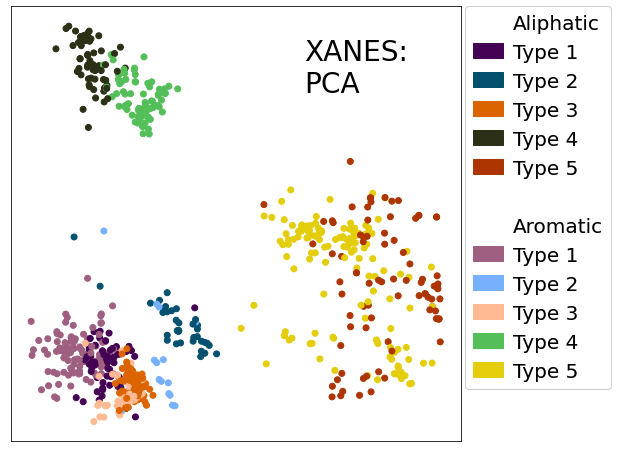

In [58]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('category', X_PCA, Labels[2],'PCA', mode='XANES')

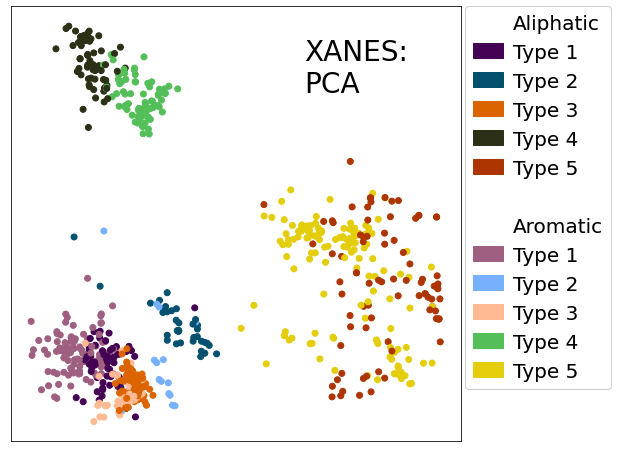

In [59]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('category', X_PCA, Labels[2],'PCA', mode='XANES')

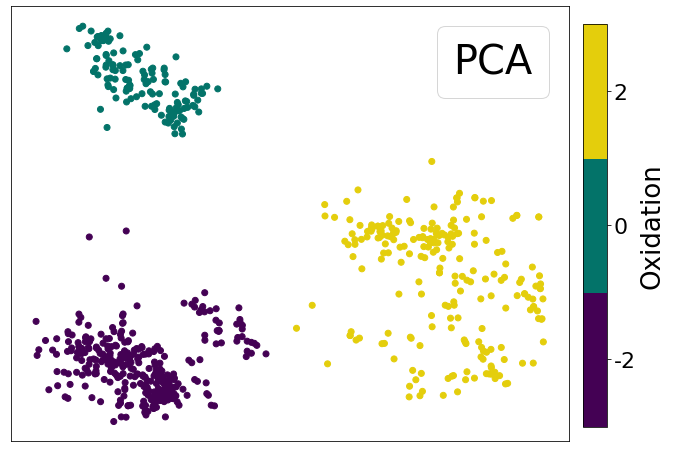

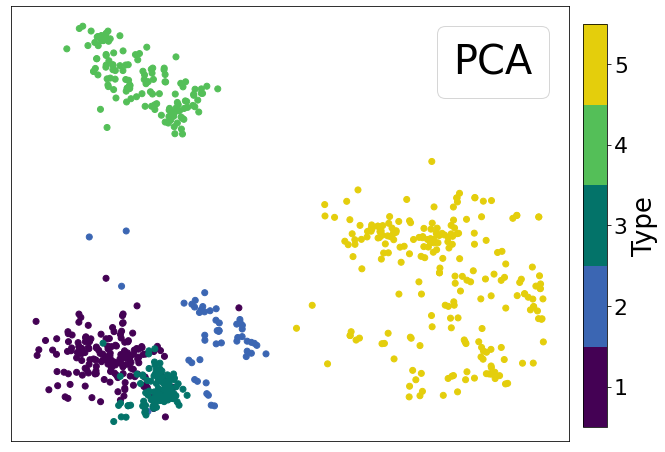

In [60]:
for PROPERTY in PROPERTIES[:2]:
    plot_dim_red(PROPERTY, X_PCA, Labels[PROPERTIES.index(PROPERTY)],'PCA', mode='XANES')

In [61]:
def make_scree(evals, n):

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(n)+1
    colors = plt.cm.viridis(np.arange(N)/N)

    avg = np.zeros(n)
    for i in range(N):
        y = evals[i]
        y = y/np.sum(y)
#         if i%100 is 0:
#             ax.plot(x, y, markersize=1, color=colors[i])
        avg += y
    
    avg = avg/N
    ax.plot(x, avg, markersize=1, color='k', label='Average')

    plt.title("Scree Plot: XANES", fontsize=20)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Principal Component', fontsize=16)
    plt.ylabel(f'Propertion of Variance Explained', fontsize=16)
    
    plt.legend()

    plt.show()
    
    return avg

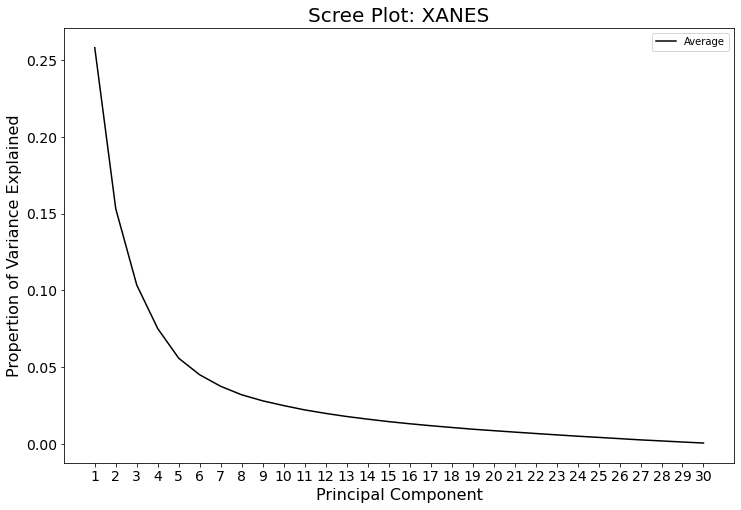

In [62]:
n = 30
pca = PCA(n_components=n)
pca.fit(X)
X_PCA = pca.transform(X)
evals = np.sort(np.abs(X_PCA), axis=1)
evals = np.flip(evals, axis=1)[:,:n]
xanes_pc = make_scree(evals, n)

In [63]:
xes_pc = np.array(['0.2099057', '0.1261262', '0.0936162', '0.0747139', '0.0609194',
       '0.0498248', '0.0430906', '0.0367303', '0.0319890', '0.0283283',
       '0.0251460', '0.0222887', '0.0200581', '0.0183026', '0.0167693',
       '0.0153394', '0.0140804', '0.0129600', '0.0119433', '0.0110746',
       '0.0103112', '0.0095227', '0.0088531', '0.0082462', '0.0077337',
       '0.0072569', '0.0068053', '0.0063984', '0.0060134', '0.0056523'], dtype=float)

In [64]:
def make_stacked_scree(xes, xanes, n=None):
    
    if n is None:
        n = len(xanes)
    else:
        xes = xes[:n]
        xanes = xanes[:n]

    fig, ax = plt.subplots(figsize=(10, 8))

    x = np.arange(n)+1

    ax.plot(x, xes, 's-', markersize=10, fillstyle='none', color=COLORS[1], label='VtC-XES')
    ax.plot(x, xanes, 'o-', markersize=10, color=COLORS[3], label='XANES')
    

    plt.xticks(x, fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Number of Parameters', fontsize=24)
    plt.ylabel(f'Fraction of Contribution\n(Averaged Over Data)', fontsize=24)
    plt.xlim(0,n+1)
    ax.tick_params(direction='in', width=2, length=8)
    
    plt.legend(fontsize=26)

    plt.show()

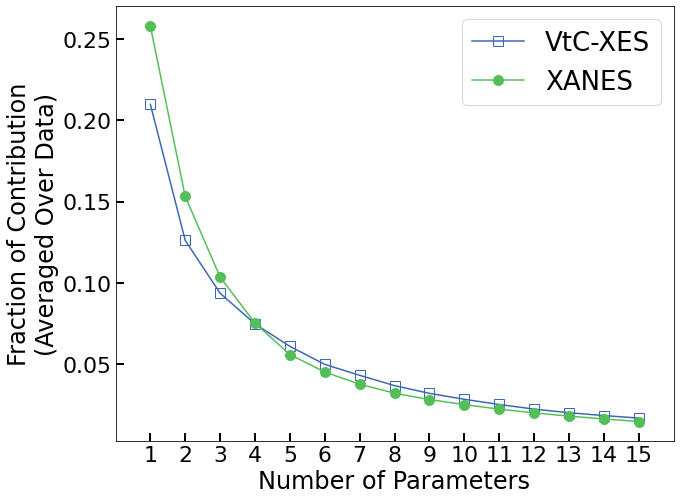

In [65]:
make_stacked_scree(xes_pc, xanes_pc, n=15)

1,3-Thiazol-4-ylacetic_acid


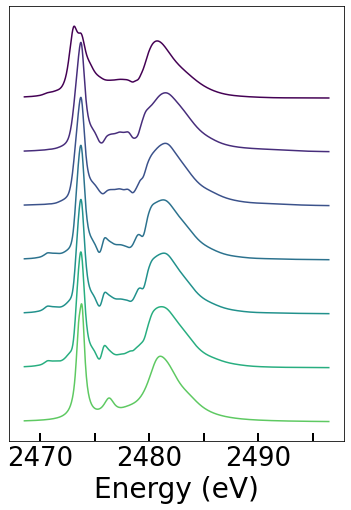

1,3-thiazolidin-2-one-sulfone


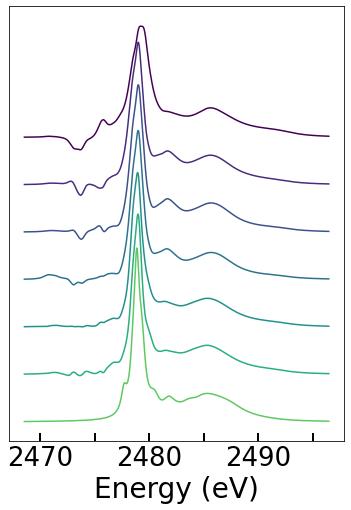

In [66]:
for i in [0, 498]:
    Recon = []
    Names = []

    s, e = 50,-50

    for nc in [2,4,6,8,10,12]:
        pca = PCA(n_components=nc)
        pca.fit(X)
        X_PCA = pca.transform(X)
        recon = pca.inverse_transform(X_PCA)
        Recon.append(recon[i].copy()[s:e])
        Names.append(f"{nc} PCs")

    x = X[i]
    name = Data[i]['name']
    print(name)

    Recon.append(x[s:e])
    Names.append('Target')
    stack_plot(XANESenergy[s:e], Recon, Names, '', space=0.2, figsize=(6,8),
               fontsize=24, leg=0, ncol=1, method='XANES')

# Other dimension Reduction!!!

In [67]:
# KNN = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(z_mean)
# distances, indices = KNN.kneighbors(z_mean)
# Thank you to:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
#sphx-glr-auto-examples-neighbors-plot-classification-py

def KNN_2D(dim_reducer, train_labels, method, n_neighbors = 40, h = .01, scheme=2, plot=True,
          val=False, normalize=True):

    if val:
        X_train, Y_train = shuffle_xy(X, one_hot_to_num(train_labels))
        train_size = 657
        X_test = X_train[train_size:].copy()
        Y_test = Y_train[train_size:].copy()
        X_train = X_train[:train_size].copy()
        Y_train = Y_train[:train_size].copy()
        
        if method is 'VAE':
            D_train = dim_reducer.predict(X_train, batch_size=20)[0]
            D_test = dim_reducer.predict(X_test, batch_size=20)[0]
        else:
            dim_reducer = dim_reducer.fit(X_train)
            D_train = dim_reducer.transform(X_train)
            D_test = dim_reducer.transform(X_test)
    else:
        X_train, Y_train = shuffle_xy(X, one_hot_to_num(train_labels))
        X_test = TEST_XANES.copy()
        
        if method is 'VAE':
            D_train = dim_reducer.predict(X_train, batch_size=20)[0]
            D_test = dim_reducer.predict(X_test, batch_size=5)[0]
        else:
            dim_reducer = dim_reducer.fit(X_train)
            D_train = dim_reducer.transform(X_train)
            D_test = dim_reducer.transform(X_test)
            
        if scheme == 1:
            Y_test = TEST_OXY
        elif scheme == 2:
            Y_test = TEST_TYPE
        else:
            Y_test = TEST_CAT
    
    fontsize=22
    
    if normalize:
        Std = np.std(D_train, axis=0)
        Mean = np.mean(D_train, axis=0)
        D_train -= Mean
        D_train /= Std
        D_test -= Mean
        D_test /= Std   
    
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(D_train, Y_train)
    
    x_min, x_max = np.min(D_train[:,0]), np.max(D_train[:,0])
    y_min, y_max = np.min(D_train[:,1]), np.max(D_train[:,1])
    
    buffer = np.abs(x_max - x_min)*0.05
    h = (np.abs(x_max - x_min) + 2*buffer) / 100
    
    xx, yy = np.meshgrid(np.arange(x_min-buffer, x_max+buffer, h), np.arange(y_min-buffer, y_max+buffer, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # getting test accuracy
    pred = clf.predict(D_test)
    Accuracy = sum(1 for i in range(len(pred)) if pred[i] == Y_test[i])/len(pred)
    markers = []
    for i in range(len(pred)):
        if pred[i] == Y_test[i]:
            markers.append('o')
        else:
            markers.append('x')

    if plot:
        cbar_vis = True
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
#         fig, ax = plt.subplots(figsize=(12, 8))
        if scheme == 1:
            cmap = ListedColormap([COLORS[0], COLORS[2], COLORS[4]])
            loc = [-1.33, 0, 1.33]
        elif scheme == 2:
            cmap = ListedColormap(COLORS)
        elif scheme == 3:
            Colors = list(COLORMAP(np.arange(1,11)/9))
            # type 1
            Colors[0] = COLORS[0].copy()
            Colors[1] = '#9F5F80'
            # type 2
            Colors[2] = '#03506F'
            Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            # type 3
            Colors[4] = '#DB6400' 
            Colors[5] = '#ffba93' 
            # type 4
            Colors[6] = '#2b3016' 
            Colors[7] = COLORS[3].copy()
            # type 5
            Colors[8] = '#ac3501'
            Colors[9] = COLORS[4]
            cmap = ListedColormap(Colors)
        
        plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.1)

        if scheme == 1:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train*2-4, cmap=cmap)
            ticks=Oxys
            title = 'Oxidation'       
        elif scheme == 2:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            ticks=Types
            loc = [1.4, 2.2, 3, 3.8, 4.6]
            title = 'Types'
        elif scheme == 3:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            cbar_vis = False
            title = 'Category'

        if cbar_vis:
#             cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
#             cbar= plt.colorbar(cax=cbaxes, ticks=ticks)
            cbar= plt.colorbar(ticks=ticks)
            cbar.set_label(title, fontsize=26)
            cbar.set_ticks(loc)
            cbar.ax.tick_params(labelsize=22)
            cbar.set_ticklabels(ticks)
            black_o = mlines.Line2D([], [], color='k', marker='o', linestyle='None', fillstyle='none',
                              markersize=10, label='Correct')
            black_x = mlines.Line2D([], [], color='k', marker='x', linestyle='None', fillstyle='none',
                              markersize=10, label='Incorrect')
            ax.legend(handles=[black_o, black_x], fontsize=22)
        else:
            t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
            t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
            t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
            t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
            t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
            t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
            t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
            t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
            t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
            t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
            space = mpatches.Patch(color='w', label='')
            fig.subplots_adjust(right=0.75)
#             plt.legend(handles=[t1a, t1b, space, t2a, t2b, space, t3a, t3b, space, t4a, t4b, space, t5a, t5b],
#                 fontsize=14, bbox_to_anchor=(1.02, 0.97), borderaxespad=0.)
            
        for i in range(len(D_test)):
            plt.plot(D_test[i, 0], D_test[i, 1], marker=markers[i], c='k', markersize=10, fillstyle='none')

        plt.title(f'{method}: {100*Accuracy:.1f}% Accuracy', fontsize=30)
        plt.axis('off')
        plt.ylim(y_min-buffer, y_max+buffer)
        plt.show()
    else:
        if scheme == 1:
            title = 'Oxidation'
        elif scheme == 2:
            title = 'Types'
        else:
            title = 'Category'
        print(f"KNN on {method}: {title} (Accuracy: {Accuracy:.2f})")
        return Accuracy

In [68]:
# KNN = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(z_mean)
# distances, indices = KNN.kneighbors(z_mean)
# Thank you to:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
#sphx-glr-auto-examples-neighbors-plot-classification-py

def KNN_tsne(X_red, train_labels, method, TEST_SIZE, n_neighbors = 40, h = .01, scheme=2, plot=True,
          normalize=True):

    D_train = X_red[:-TEST_SIZE,:]
    Y_train = one_hot_to_num(train_labels)
    
    D_test = X_red[-TEST_SIZE:,:]
        
    if scheme == 1:
        Y_test = TEST_OXY
    elif scheme == 2:
        Y_test = TEST_TYPE
    else:
        Y_test = TEST_CAT
    
    fontsize=22
    
    if normalize:
        Std = np.std(D_train, axis=0)
        Mean = np.mean(D_train, axis=0)
        D_train -= Mean
        D_train /= Std
        D_test -= Mean
        D_test /= Std   
    
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(D_train, Y_train)
    
    x_min, x_max = np.min(D_train[:,0]), np.max(D_train[:,0])
    y_min, y_max = np.min(D_train[:,1]), np.max(D_train[:,1])
    
    buffer = np.abs(x_max - x_min)*0.05
    h = (np.abs(x_max - x_min) + 2*buffer) / 100
    
    xx, yy = np.meshgrid(np.arange(x_min-buffer, x_max+buffer, h), np.arange(y_min-buffer, y_max+buffer, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # getting test accuracy
    pred = clf.predict(D_test)
    Accuracy = sum(1 for i in range(len(pred)) if pred[i] == Y_test[i])/len(pred) 
    markers = []
    for i in range(len(pred)):
        if pred[i] == Y_test[i]:
            markers.append('o')
        else:
            markers.append('x')

    if plot:
        cbar_vis = True
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
#         fig, ax = plt.subplots(figsize=(12, 8))
        if scheme == 1:
            cmap = ListedColormap([COLORS[0], COLORS[2], COLORS[4]])
            loc = [-1.33, 0, 1.33]
        elif scheme == 2:
            cmap = ListedColormap(COLORS)
        elif scheme == 3:
            Colors = list(COLORMAP(np.arange(1,11)/9))
            # type 1
            Colors[0] = COLORS[0].copy()
            Colors[1] = '#9F5F80'
            # type 2
            Colors[2] = '#03506F'
            Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            # type 3
            Colors[4] = '#DB6400' 
            Colors[5] = '#ffba93' 
            # type 4
            Colors[6] = '#2b3016' 
            Colors[7] = COLORS[3].copy()
            # type 5
            Colors[8] = '#ac3501'
            Colors[9] = COLORS[4]
            cmap = ListedColormap(Colors)
        
        plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.1)

        if scheme == 1:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train*2-4, cmap=cmap)
            ticks=Oxys
            title = 'Oxidation'       
        elif scheme == 2:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            ticks=Types
            loc = [1.4, 2.2, 3, 3.8, 4.6]
            title = 'Types'
        elif scheme == 3:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            cbar_vis = False
            title = 'Category'

        if cbar_vis:
#             cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
#             cbar= plt.colorbar(cax=cbaxes, ticks=ticks)
            cbar= plt.colorbar(ticks=ticks)
            cbar.set_label(title, fontsize=26)
            cbar.set_ticks(loc)
            cbar.ax.tick_params(labelsize=22)
            cbar.set_ticklabels(ticks)
            black_o = mlines.Line2D([], [], color='k', marker='o', linestyle='None', fillstyle='none',
                              markersize=10, label='Correct')
            black_x = mlines.Line2D([], [], color='k', marker='x', linestyle='None', fillstyle='none',
                              markersize=10, label='Incorrect')
            ax.legend(handles=[black_o, black_x], fontsize=22)
        else:
            t1a = mpatches.Patch(color=Colors[0], label='Type 1')
            t1b = mpatches.Patch(color=Colors[1], label='Type 1')
            t2a = mpatches.Patch(color=Colors[2], label='Type 2')
            t2b = mpatches.Patch(color=Colors[3], label='Type 2')
            t3a = mpatches.Patch(color=Colors[4], label='Type 3')
            t3b = mpatches.Patch(color=Colors[5], label='Type 3')
            t4a = mpatches.Patch(color=Colors[6], label='Type 4')
            t4b = mpatches.Patch(color=Colors[7], label='Type 4')
            t5a = mpatches.Patch(color=Colors[8], label='Type 5')
            t5b = mpatches.Patch(color=Colors[9], label='Type 5')
            space = mpatches.Patch(color='w', label='')
            aro = mpatches.Patch(color='w', label='Aromatic')
            ali = mpatches.Patch(color='w', label='Aliphatic')
            
            handles = [ali, t1a,t2a, t3a, t4a, t5a, space, aro, t1b, t2b, t3b, t4b, t5b]
            leg1 = plt.legend(handles=handles, ncol=1, fontsize=20, handletextpad=0.001,
                              bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
            plt.gca().add_artist(leg1)
            i = 0
            for patch in leg1.get_patches():
                patch.set_height(15)
                if i in [0, 7]:
                    patch.set_width(0.1)
                else:
                    patch.set_width(30)
                i += 1
            fig.subplots_adjust(right=0.75)
            
            black_o = mlines.Line2D([], [], color='k', marker='o', linestyle='None', fillstyle='none',
                              markersize=10, label='Correct')
            black_x = mlines.Line2D([], [], color='k', marker='x', linestyle='None', fillstyle='none',
                              markersize=10, label='Incorrect')
            ax.legend(handles=[black_o, black_x], fontsize=22)
            
        for i in range(len(D_test)):
            plt.plot(D_test[i, 0], D_test[i, 1], marker=markers[i], c='k', markersize=10, fillstyle='none')

        plt.title(f'{method}: {100*Accuracy:.1f}% Accuracy', fontsize=30)
        plt.axis('off')
        plt.show()
    else:
        if scheme == 1:
            title = 'Oxidation'
        elif scheme == 2:
            title = 'Types'
        else:
            title = 'Category'
        print(f"KNN on {method}: {title} (Accuracy: {Accuracy:.2f})")
        return Accuracy

In [69]:
fastICA = FastICA(n_components=2)
fastICA.fit(X)
X_FastICA = fastICA.transform(X)
TEST_X_FastICA = fastICA.transform(TEST_XANES)

fa = FactorAnalysis(n_components=2)
fa.fit(X)
X_FA = fa.transform(X)
TEST_X_FA = fa.transform(TEST_XANES)

nmf = NMF(n_components=2)
nmf.fit(X)
X_NMF = nmf.transform(X)
TEST_X_NMF = nmf.transform(TEST_XANES)

pca = PCA(n_components=2)
pca.fit(X)
X_PCA = pca.transform(X)
TEST_X_PCA = pca.transform(TEST_XANES)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XANES, batch_size=5)[0]

tsne = TSNE(n_components=2, perplexity=15, random_state=30)
X_TSNE = tsne.fit_transform(X)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
C:\Users\saman\

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
C:\Users\saman\

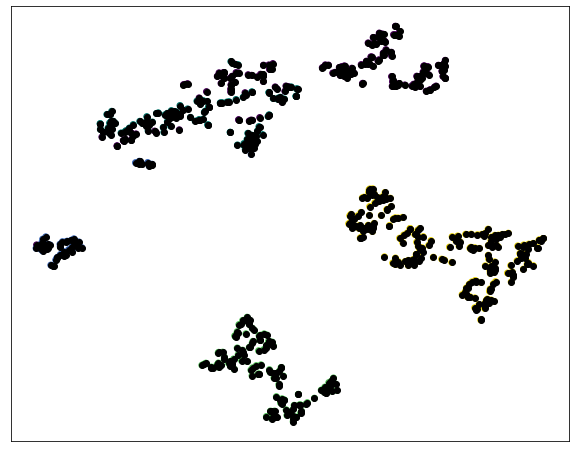

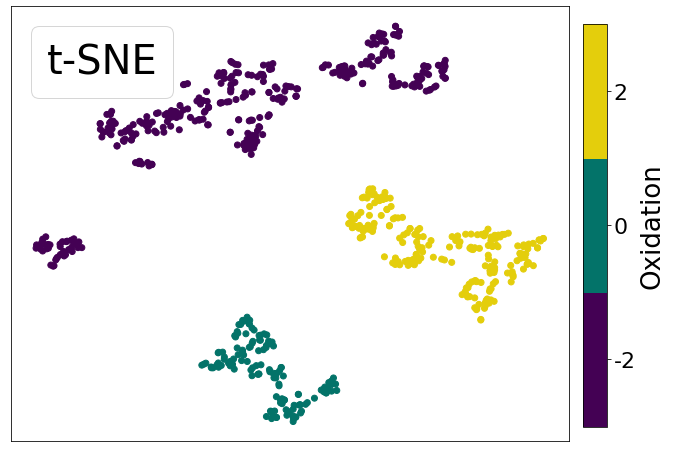

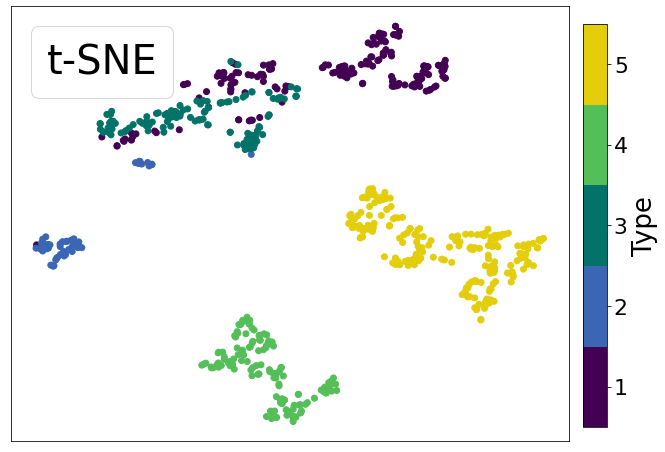

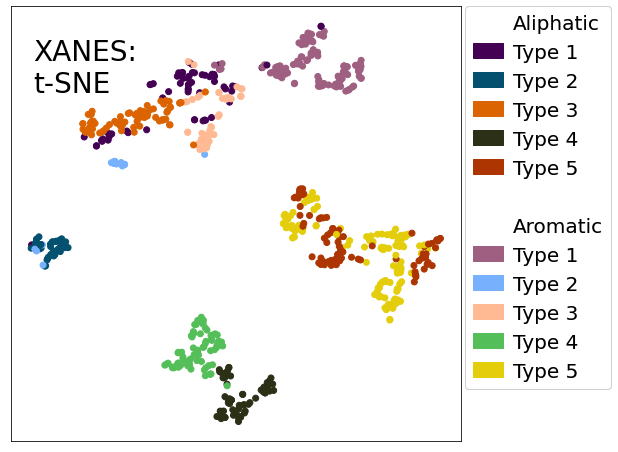

In [92]:
tsne = TSNE(n_components=2, perplexity=18, random_state=30)
X_TSNE = tsne.fit_transform(X)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('Type', X_TSNE, Labels[1],'t-SNE', black=True)
    plot_dim_red('oxy', X_TSNE, Labels[0],'t-SNE')
    plot_dim_red('Type', X_TSNE, Labels[1],'t-SNE')
    plot_dim_red('category', X_TSNE, Labels[2],'t-SNE', mode='XANES', xloc=0.05)

In [93]:
I = []
names1 = []
for i, ele in enumerate(Data):
    if ele['category'] == 2: 
        x, y = X_TSNE[i]
        if not ((x > 12 and y < 35) or x > 22):
            I.append(i)
            names1.append(NAMES[i])
I = np.array(I) 
print(len(I))
cluster1 = [get_x(name) for name in names1]
cluster1 = np.average(cluster1, axis=0)

61


In [94]:
I = []
names2 = []
for i, ele in enumerate(Data):
    if ele['category'] == 2: 
        x, y = X_TSNE[i]
        if (x > 12 and y < 35) or x > 22:
            I.append(i)
            names2.append(NAMES[i])
I = np.array(I) 
print(len(I))
cluster2 = [get_x(name) for name in names2]
cluster2 = np.average(cluster2, axis=0)

46


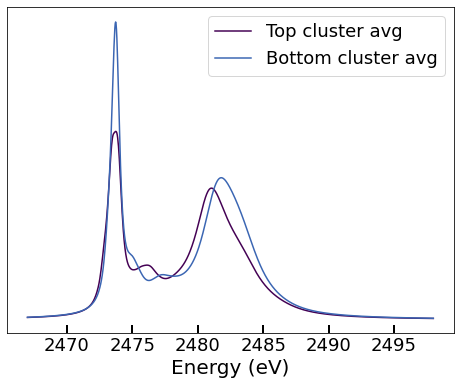

In [95]:
stack_plot(XANESenergy, [cluster1, cluster2], ['Top cluster avg', 'Bottom cluster avg'], '',
           space=0., figsize=(8,6), leg=1)

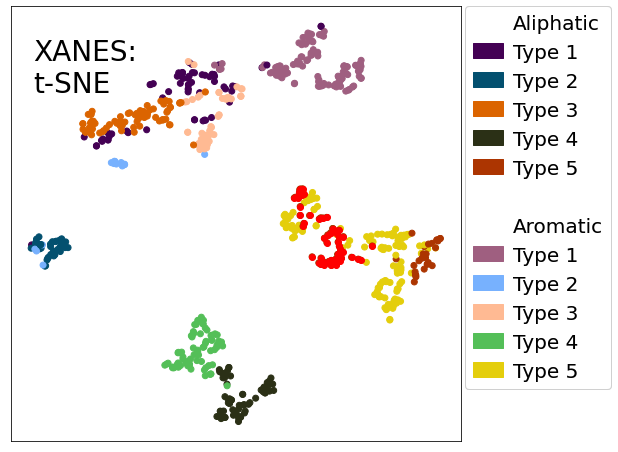

In [96]:
I = []
names_left = []
names_right = []
for i, ele in enumerate(Data):
    if ele['category'] == 9: 
        x, y = X_TSNE[i]
        if x < 35:
            I.append(i)
            names_left.append(NAMES[i])
        else:
            names_right.append(NAMES[i])
I = np.array(I)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('category', X_TSNE, Labels[2],'t-SNE', mode='XANES', xloc=0.05, Indices=I)

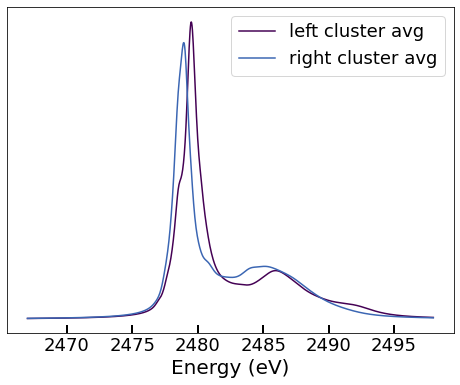

In [97]:
cluster1 = [get_x(name) for name in names_left]
cluster1 = np.average(cluster1, axis=0)

cluster2 = [get_x(name) for name in names_right]
cluster2 = np.average(cluster2, axis=0)

stack_plot(XANESenergy, [cluster1, cluster2], ['left cluster avg', 'right cluster avg'], '',
           space=0., figsize=(8,6), leg=1)

In [98]:
# energy shift
XANESenergy[np.argmax(cluster1)] - XANESenergy[np.argmax(cluster2)]

0.5585585585586159

In [99]:
nonring = ['Butylate-sulfone', 'EPTC-sulfone', 'Methyl_Thiocyanate-sulfone', 'Molinate-sulfone',
           'Pebulate-sulfone', 'S-Benzylthiourea-sulfone', 'Triallate-sulfone']
len(nonring)/len(names_right)

0.25925925925925924

C:\Users\saman\Downloads\Anaconda\lib\site-packages\matplotlib\colors.py:263: FutureWarning: Promotion of numbers and bools to strings is deprecated. In the future, code such as `np.concatenate((['string'], [0]))` will raise an error, while `np.asarray(['string', 0])` will return an array with `dtype=object`.  To avoid the warning while retaining a string result use `dtype='U'` (or 'S').  To get an array of Python objects use `dtype=object`. (Warning added in NumPy 1.21)
  c = np.array(c)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


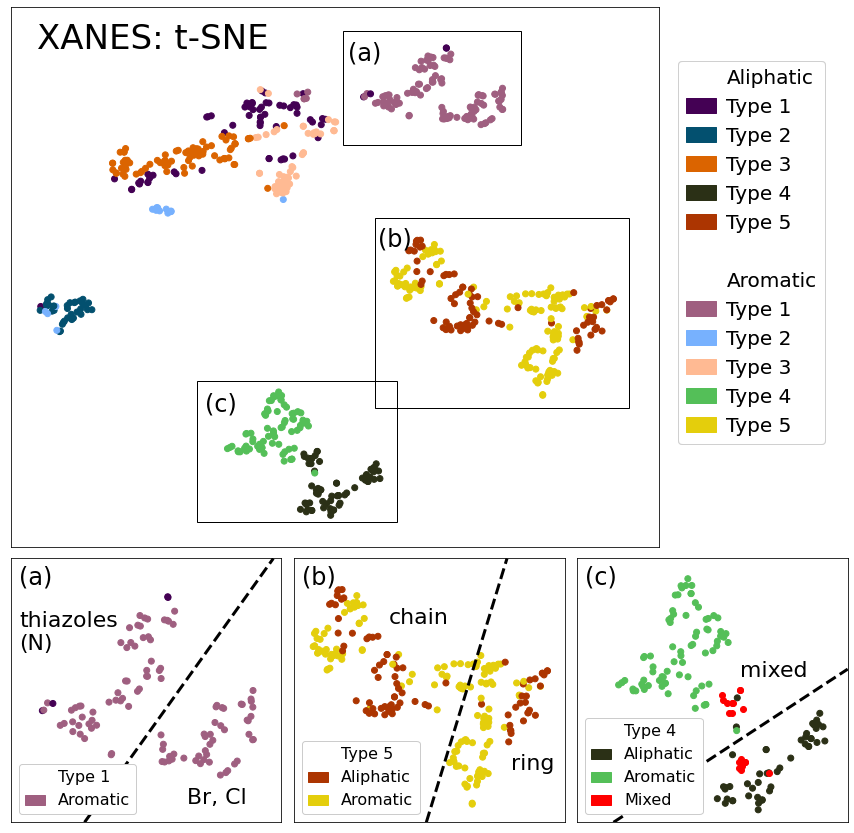

In [127]:
def cluster_ana2(X_red, Y, method, Indices=None, Special_labels=None):
    
    Colors = list(COLORMAP(np.arange(1,11)/9))
    mode='XANES'
    fontsize=24
            
    # type 1
    Colors[0] = COLORS[0].copy()
    Colors[1] = '#9F5F80'
    # type 2
    Colors[2] = '#03506F'
    Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
    # type 3
    Colors[4] = '#DB6400'
    Colors[5] = '#ffba93'
    # type 4
    Colors[6] = '#2b3016' 
    Colors[7] = COLORS[3].copy()
    # type 5
    Colors[8] = '#ac3501'
    Colors[9] = COLORS[4]

    fig = plt.figure(figsize=(15,15))
    grid = plt.GridSpec(9, 9, wspace=0.15, hspace=0.15)
    
    bigax = plt.subplot(grid[:6, :7])
    ax1 =  plt.subplot(grid[6:, :3])
    ax2 =  plt.subplot(grid[6:, 3:6])
    ax3 =  plt.subplot(grid[6:, 6:])
    axes = [ax1, ax2, ax3]
    
    labels = ['a', 'b', 'c']
        
    Y = one_hot_to_num(Y)
    cmap = ListedColormap(Colors)
    
    Xlims = [(-1, 32), (5, 52), (-28, 9)]
    Ylims = [(25, 50), (-33, 9), (-58,-27)]
    Alphas = [1., 1., 1.]
    
    # type 1
    t1 = mpatches.Patch(color='w', label='Type 1')
    t1aro = mpatches.Patch(color=Colors[1], label='Aromatic')
    
    # type 4
    scolor = '#ff0000'
    t4 = mpatches.Patch(color='w', label='Type 4')
    t4ali = mpatches.Patch(color=Colors[6], label='Aliphatic')
    t4aro = mpatches.Patch(color=Colors[7], label='Aromatic')
    t4mix = mpatches.Patch(color=scolor, label='Mixed')
    
    # type 5
    t5 = mpatches.Patch(color='w', label='Type 5')
    t5ali = mpatches.Patch(color=Colors[8], label='Aliphatic')
    t5aro = mpatches.Patch(color=Colors[9], label='Aromatic')
    
    Handles = [[t1, t1aro], [t5, t5ali, t5aro], [t4, t4ali, t4aro, t4mix]]
    
    for i, ax in enumerate(axes):
        
        ax.set_xlim(Xlims[i])
        ax.set_ylim(Ylims[i])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
        if i == 2:
            # plotting normal
            other_indices = list(set(np.arange(len(X_red))) - set(Indices))
            superset = X_red[other_indices]
            ax.scatter(superset[:, 0], superset[:, 1], c=Y[other_indices], cmap=cmap, alpha=Alphas[i])
            
            circle = plt.Circle((-5.2, -48), 6.8, lw=3, color='#000000',
                                 linestyle='--', fill=False)            
            # plotting mixed
            subset = X_red[Indices]
            ax.scatter(subset[:,0], subset[:,1], color=scolor)
                
            xs = np.linspace(Xlims[i][0] + 5, Xlims[i][1], 10)
            ys = np.linspace(Ylims[i][0], Ylims[i][1] - 13, 10)
            
            xy = (0.6, 0.55)
            ax.annotate('mixed',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
            
        elif i == 0:
            ax.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap, alpha=Alphas[i])
            xs = np.linspace(Xlims[i][0] + 9, Xlims[i][1] - 1, 10)
            ys = np.linspace(Ylims[i][0], Ylims[i][1], 10)
            
            xy = (0.032, 0.65)
            ax.annotate('thiazoles\n(N)',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
            
            xy = (0.65, 0.07)
            ax.annotate('Br, Cl',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
            
        elif i == 1:
            ax.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap, alpha=Alphas[i])
            xs = np.linspace(Xlims[i][0] + 23, Xlims[i][1] - 10, 10)
            ys = np.linspace(Ylims[i][0], Ylims[i][1], 10)
            
            xy = (0.35, 0.75)
            ax.annotate('chain',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
            
            xy = (0.8, 0.2)
            ax.annotate('ring',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
        

        # for all plots
        ax.plot(xs, ys, c='k', linestyle='--', linewidth=3)
        # annotation
        xy = (0.03, 0.9)  
        ax.annotate(f'({labels[i]})',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize)
        # legend
        leg = ax.legend(handles=Handles[i], loc=3, framealpha=1.,
                        fontsize=fontsize-8, handletextpad=0.05)
        for patch in leg.get_patches():
            patch.set_height(10)
            patch.set_width(20)

    
    bigax.axes.xaxis.set_visible(False)
    bigax.axes.yaxis.set_visible(False)
    
    bigax.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap)
    
    XYs = [(0.52, 0.9), (0.565, 0.555), (0.3, 0.25)]

    for i in range(3):
        xlim = Xlims[i]
        ylim = Ylims[i]
        width = xlim[1] - xlim[0]
        height = ylim[1] - ylim[0]
        box = plt.Rectangle((xlim[0], ylim[0]), width, height, lw=1, color='#000000',
                            linestyle='-', fill=False)
        bigax.add_patch(box)
        
        xy = XYs[i]  
        bigax.annotate(f'({labels[i]})',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize)
    xy = 0.04, 0.92
    bigax.annotate(f'{mode}: {method}',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize + 10)    
        
    t1a = mpatches.Patch(color=Colors[0], label='Type 1')
    t1b = mpatches.Patch(color=Colors[1], label='Type 1')
    t2a = mpatches.Patch(color=Colors[2], label='Type 2')
    t2b = mpatches.Patch(color=Colors[3], label='Type 2')
    t3a = mpatches.Patch(color=Colors[4], label='Type 3')
    t3b = mpatches.Patch(color=Colors[5], label='Type 3')
    t4a = mpatches.Patch(color=Colors[6], label='Type 4')
    t4b = mpatches.Patch(color=Colors[7], label='Type 4')
    t5a = mpatches.Patch(color=Colors[8], label='Type 5')
    t5b = mpatches.Patch(color=Colors[9], label='Type 5')
    space = mpatches.Patch(color='w', label='')
    aro = mpatches.Patch(color='w', label='Aromatic')
    ali = mpatches.Patch(color='w', label='Aliphatic')
            
    handles = [ali, t1a,t2a, t3a, t4a, t5a, space, aro, t1b, t2b, t3b, t4b, t5b]
    big_legend = bigax.legend(handles=handles, ncol=1, fontsize=20, handletextpad=0.001,
                              bbox_to_anchor=(1.03, 0.9), loc=2, borderaxespad=0.)
    bigax.add_artist(big_legend)
    for patch in big_legend.get_patches():
        patch.set_height(15)
        patch.set_width(30)

###################################################################################

# ax 1 focus
type4_special_indices = []
for i, ele in enumerate(Data):
    if ele['Mixed'] == 1: 
        type4_special_indices.append(i)
type4_special_indices = np.array(type4_special_indices)

cluster_ana2(X_TSNE, Labels[2], 't-SNE', Indices=type4_special_indices)

In [101]:
# Triclabendazole and Albendazole (mixed aro and ali are more similar to aliphatic, not aromatic)
# the purple type 1 in the type 2 cluster is probably gamma-Thiobutyrolactone

Carbonyl_Sulfide: 50


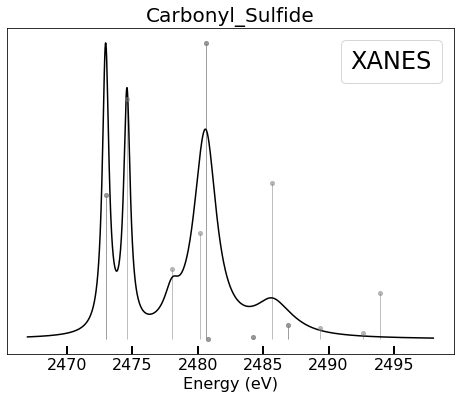

In [102]:
for name in ['Carbonyl_Sulfide']:
    index = NAMES.index(name)

    x = get_Spectrum(Data, name, mode='XANES')[1]/SCALING_FACTOR
    trans = Data[index]['Transitions']
    print(f'{name}: {len(trans[0])}')

    plot_spectrum_and_trans(adjust_trans(trans, x), [XANESenergy, x], f'{name}', figsize=(8,6),
                            label='XANES')

4-2-hydroxyphenylsulfinyl-butylphosphonic_acid: 50


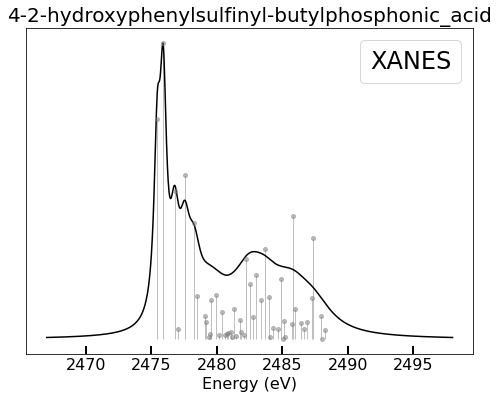

In [103]:
check_these = ['4-2-hydroxyphenylsulfinyl-butylphosphonic_acid']
# for name in names:
for name in check_these:
    index = NAMES.index(name)

    x = get_Spectrum(Data, name, mode='XANES')[1]/SCALING_FACTOR
    trans = Data[index]['Transitions']
    print(f'{name}: {len(trans[0])}')

    plot_spectrum_and_trans(adjust_trans(trans, x), [XANESenergy, x], f'{name}', figsize=(8,6),
                            label='XANES')

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
C:\Users\saman\

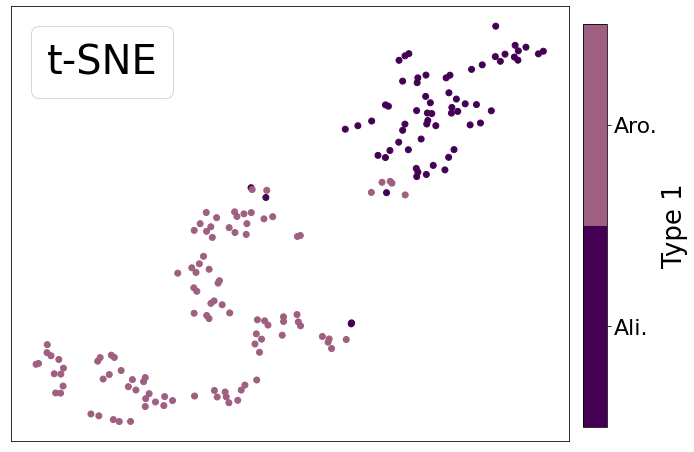

In [104]:
# 'Aliphatic' vs 'Aromatic' per type t-SNE
select_type = 1
x_one = []
y_one = []
names_one = []
for ele in Data:
    if ele['Type'] == select_type:
        x = ele['XANES'][1]
        x = x/SCALING_FACTOR
        x_one.append(x)
        y = ele['conj']
        y_one.append(y)
        names_one.append(ele['name'])

x_one = np.array(x_one)
y_one = np.array(y_one)

tsne = TSNE(n_components=2, perplexity=15, random_state=30)
X_TSNE_one = tsne.fit_transform(x_one)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red(select_type, X_TSNE_one, y_one,'t-SNE')

### The two dark purple aliphatic in the aromatic cluster are gamma-Thiobutyrolactone and Triclabendazole.

gamma-Thiobutyrolactone:
<img src="https://www.sigmaaldrich.com/content/dam/sigma-aldrich/structure7/191/mfcd00005479.eps/_jcr_content/renditions/mfcd00005479-medium.png" alt="drawing" width="100"/>

Triclabendazole:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Triclabendazole.svg/215px-Triclabendazole.svg.png" alt="drawing" width="250"/>

### The two light purple aromatic in the aliphatic cluster are Perphenazine andTrimeprazine

In [83]:
# bool_arr = y_one == 1
# for i,pt in enumerate(X_TSNE_one):
#     x, y = pt
#     if y < -2.5 and bool_arr[i]:
#         print(names_one[i])

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
C:\Users\saman\

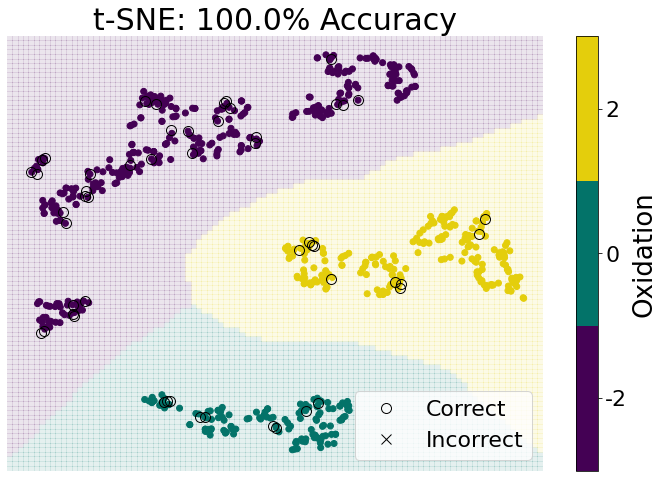

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


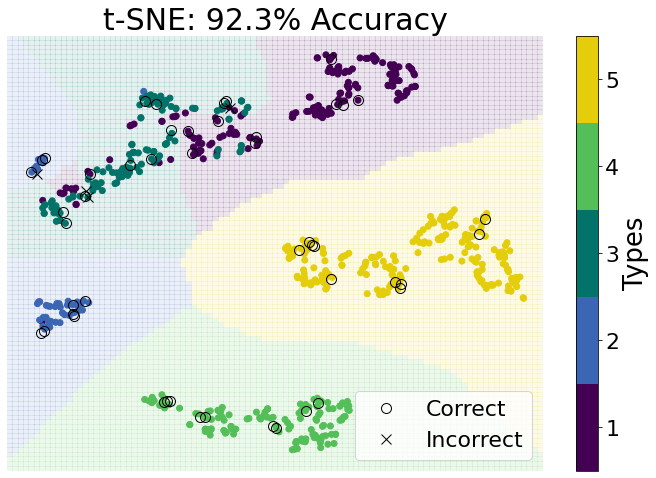

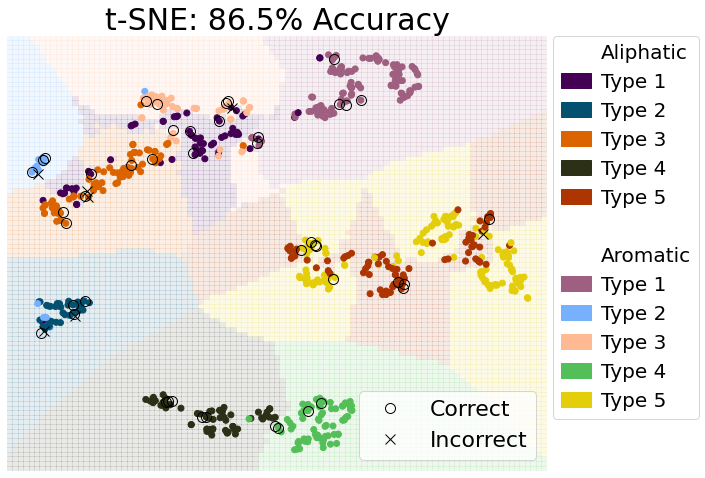

In [84]:
tsne = TSNE(n_components=2, perplexity=18, random_state=30)
everything = list(X)
for x in TEST_XANES:
    everything.append(x)
everything = np.array(everything)
X_TSNE = tsne.fit_transform(everything)
TEST_SIZE = len(TEST_XANES)

i = 0
KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=20)
i = 1
KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=20)
i = 2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=10)

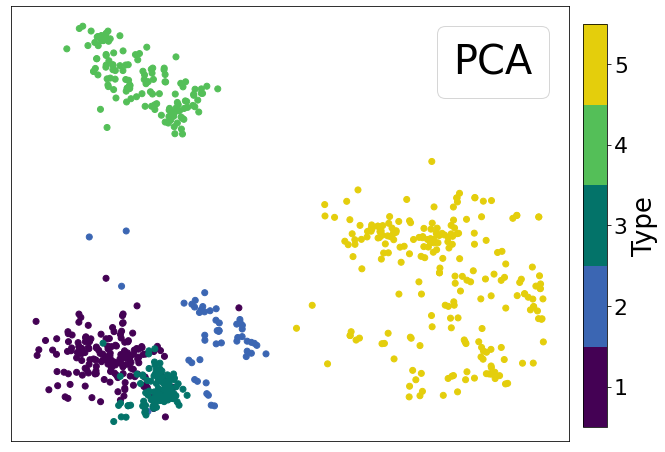

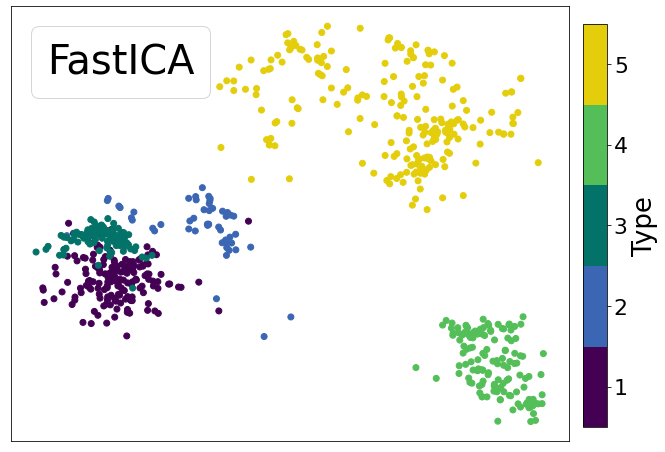

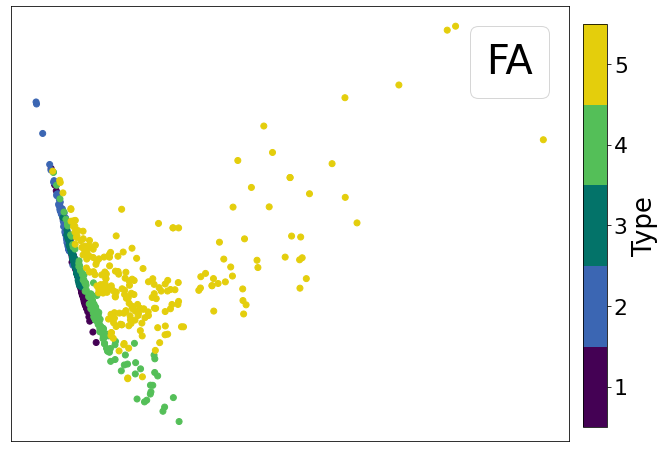

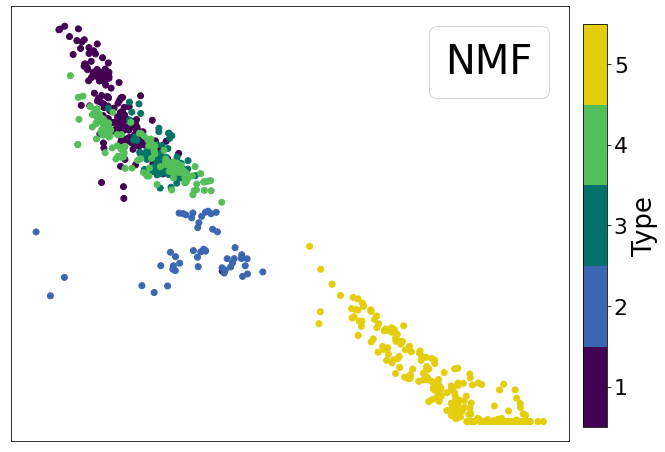

In [85]:
plot_dim_red('Type', X_PCA, Labels[1],'PCA')
plot_dim_red('Type', X_FastICA, Labels[1],'FastICA')
plot_dim_red('Type', X_FA, Labels[1],'FA')
plot_dim_red('Type', X_NMF, Labels[1],'NMF')

In [86]:
fastICA = FastICA(n_components=2)

fa = FactorAnalysis(n_components=2)

nmf = NMF(n_components=2)

pca = PCA(n_components=2)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XANES)[0]

In [87]:
Acc = [[],[],[]]
print("Oxidation:")
neis = 20
i = 0
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))
print("\nType:")
neis = 20
i = 1
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))
print("\nAro:")
neis = 10
i = 2
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))

Oxidation:


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

KNN on VAE: Oxidation (Accuracy: 1.00)
KNN on PCA: Oxidation (Accuracy: 1.00)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


KNN on FastICA: Oxidation (Accuracy: 1.00)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


KNN on FA: Oxidation (Accuracy: 0.92)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

KNN on NMF: Oxidation (Accuracy: 0.90)
KNN on t-SNE: Oxidation (Accuracy: 1.00)

Type:


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

KNN on VAE: Types (Accuracy: 0.90)
KNN on PCA: Types (Accuracy: 0.90)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


KNN on FastICA: Types (Accuracy: 0.90)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


KNN on FA: Types (Accuracy: 0.71)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

KNN on NMF: Types (Accuracy: 0.88)
KNN on t-SNE: Types (Accuracy: 0.92)

Aro:


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

KNN on VAE: Category (Accuracy: 0.75)
KNN on PCA: Category (Accuracy: 0.69)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


KNN on FastICA: Category (Accuracy: 0.69)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


KNN on FA: Category (Accuracy: 0.56)
KNN on NMF: Category (Accuracy: 0.67)
KNN on t-SNE: Category (Accuracy: 0.87)


C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

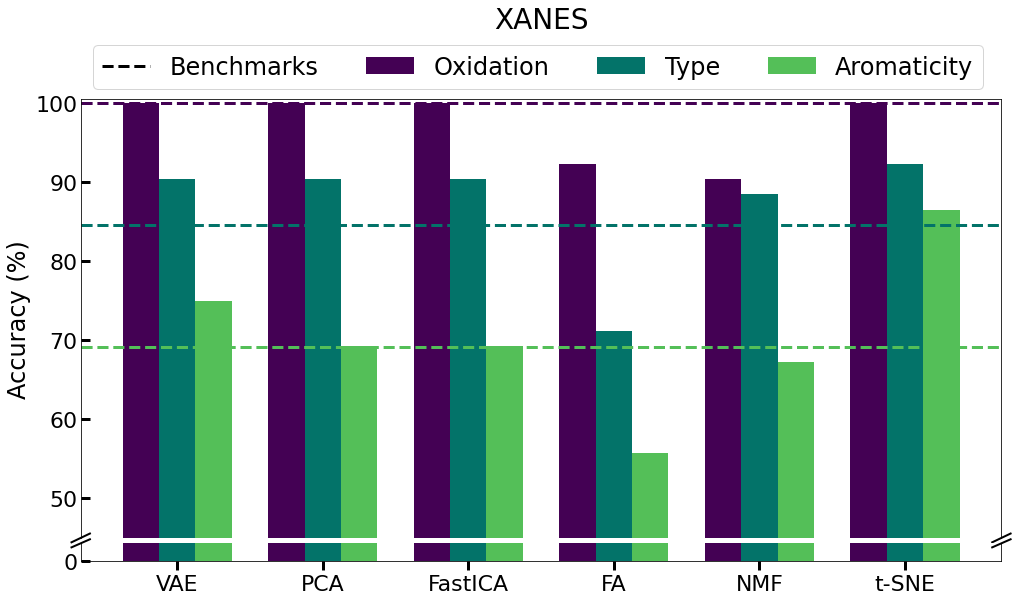

In [88]:
bar_chart(Acc, [100,84.6,69.2], mode='XANES')

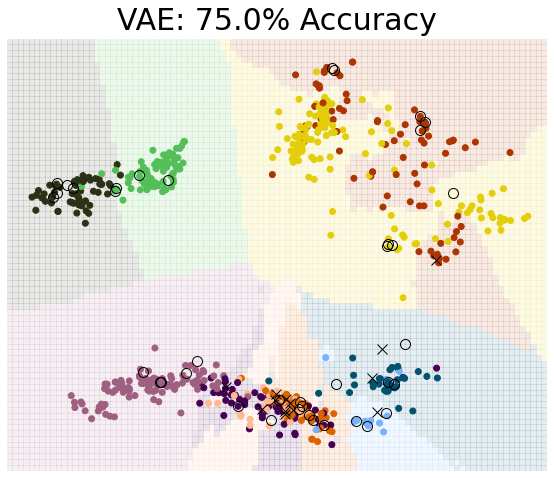

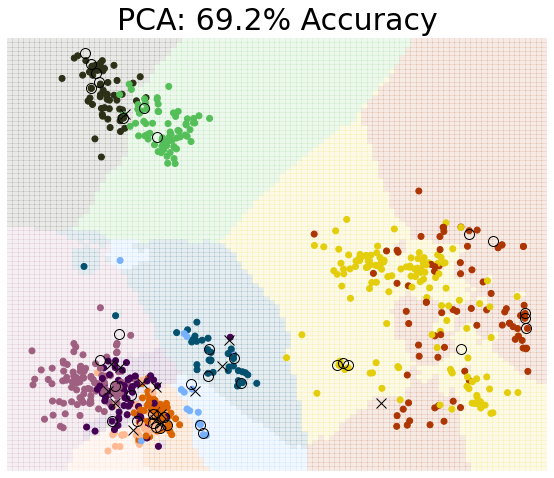

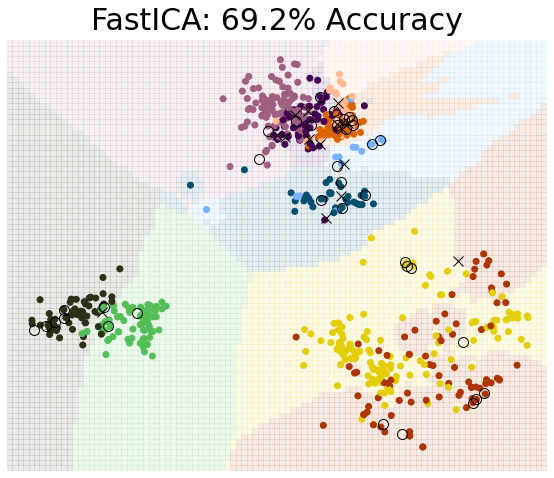

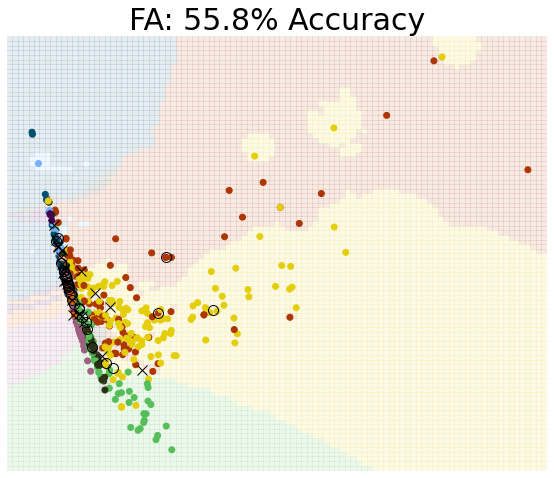

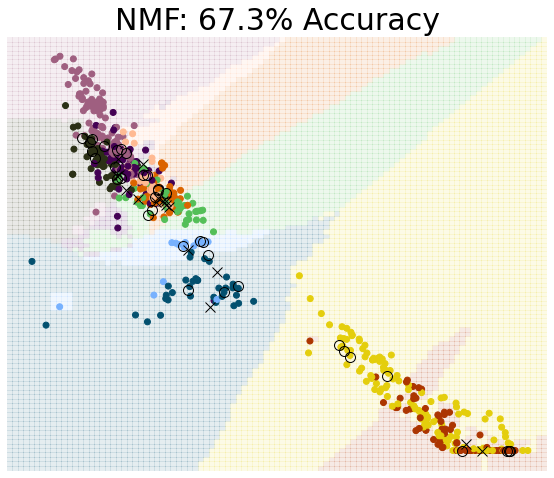

In [89]:
neis = 10
i = 2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis)
    KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis)
    KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis)
    KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis)
    KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis)

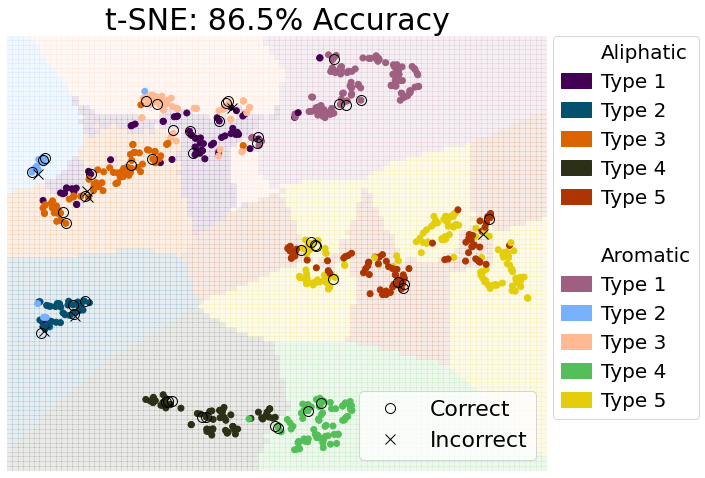

In [90]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=10)